<a href="https://colab.research.google.com/github/AbdulmagedALKHULAIFI/projet7_data_science/blob/main/P7_02_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Installation

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
source_path = "/content/drive/MyDrive/OC/Projet 7/source/"
data_path = "/content/drive/MyDrive/OC/Projet 7/data/" 

In [4]:
!pip install -r /content/drive/MyDrive/'Colab Notebooks'/requirements.txt


#Import

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pickle import *

# Model
import lightgbm as lgb
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score, confusion_matrix
from sklearn.metrics import average_precision_score, log_loss, accuracy_score, classification_report
from bayes_opt import BayesianOptimization
import shap
from pycaret.classification import *

# Configuration
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.options.display.float_format = '{:,.2f}'.format

In [6]:
from P7_01_functions import *
import P7_01_functions
help(P7_01_functions)

Help on module P7_01_functions:

NAME
    P7_01_functions - Fichier contenant les fonctions du P7

FUNCTIONS
    cat_analyzer(dataframe, variable, target=None)
        Categorical Variables & Target
    
    corr_plot(data, remove=['Id'], corr_coef='pearson', figsize=(20, 20))
        Numerical Variables
    
    display_importances(feature_importance_df_)
    
    display_precision_recall(y_, oof_preds_, folds_idx_)
    
    display_roc_curve(y_, oof_preds_, folds_idx_)
    
    grab_col_names(dataframe, cat_th=10, car_th=20, show_date=False)
        Grab Column Names
    
    high_correlation(data, remove=['SK_ID_CURR', 'SK_ID_BUREAU'], corr_coef='pearson', corr_value=0.7)
        Get high correlated variables
    
    missing_values(data, plot=False)
        Missing Value
    
    num_plot(data, num_cols, remove=['Id'], hist_bins=10, figsize=(20, 4))
        Plot numerical variables
    
    one_hot_encoder(df, nan_as_category=True)
        One-hot encoding for categorical columns w

**Note :**

Pour mon sommaire, j'utilise l'extension Table of Contents de Jupyter : 
https://jupyter-contrib-nbextensions.readthedocs.io/en/latest/nbextensions/toc2/README.html
    
Toute la partie exploration de données vient de Kaggle : https://www.kaggle.com/ekrembayar/homecredit-default-risk-step-by-step-1st-notebook

In [7]:
col_description = pd.read_csv(data_path + "HomeCredit_columns_description.csv", encoding = 'latin1',)
col_description.head()

,Unnamed: 0,Table,Row,Description,Special
0,1,application_{train|test}.csv,SK_ID_CURR,ID of loan in our sample,NaN
1,2,application_{train|test}.csv,TARGET,Target variable (1 - client with payment diffi...,NaN
2,5,application_{train|test}.csv,NAME_CONTRACT_TYPE,Identification if loan is cash or revolving,NaN
3,6,application_{train|test}.csv,CODE_GENDER,Gender of the client,NaN
4,7,application_{train|test}.csv,FLAG_OWN_CAR,Flag if the client owns a car,NaN


In [8]:
col_description[col_description['Row'] == 'TARGET']['Description']

1    Target variable (1 - client with payment diffi...
Name: Description, dtype: object

Variable cible (1 - client ayant des difficultés de paiement : il/elle a eu un retard de paiement de plus de X jours sur au moins une des Y premières échéances du prêt dans notre échantillon, 0 - tous les autres cas)

# 1. Exploration de données


Import et exploration  de tables :

- Afficher les dimension des tables et observer les différences 

- Vérifier si la variable cible est bien équilibré/distribué


In [9]:
train = pd.read_csv(data_path + "application_train.csv")
test = pd.read_csv(data_path + "application_test.csv")
bureau = pd.read_csv(data_path + "bureau.csv")
bureau_balance = pd.read_csv(data_path + "bureau_balance.csv")
pos = pd.read_csv(data_path + "POS_CASH_balance.csv")
cc = pd.read_csv(data_path + "credit_card_balance.csv")
ins = pd.read_csv(data_path + "installments_payments.csv")
prev = pd.read_csv(data_path + "previous_application.csv")

In [10]:
train['TARGET'].value_counts()

0    282686
1     24825
Name: TARGET, dtype: int64

In [11]:
print("Dimensions")

dict_df = {'application_train shape :': train.shape, 
           'application_test shape :' : test.shape, 
           'bureau shape :' : bureau.shape,
           'bureau_balance shape :' : bureau_balance.shape,
           'POS_CASH_balance shape :' : pos.shape, 
           'credit_card_balance shape :' : cc.shape, 
           'installments_payments shape :' : ins.shape, 
           'previous_application shape:' : prev.shape}

for key, value in dict_df.items():
    print(f'{key :-<30} {value}')

Dimensions
application_train shape :----- (307511, 122)
application_test shape :------ (48744, 121)
bureau shape :---------------- (1716428, 17)
bureau_balance shape :-------- (27299925, 3)
POS_CASH_balance shape :------ (10001358, 8)
credit_card_balance shape :--- (3840312, 23)
installments_payments shape :- (13605401, 8)
previous_application shape:--- (1670214, 37)


In [12]:
print("Missing values")

dict_df = {'application_train :': train, 
           'application_test :' : test, 
           'bureau :' : bureau,
           'bureau_balance :' : bureau_balance,
           'POS_CASH_balance :' : pos, 
           'credit_card_balance :' : cc, 
           'installments_payments :' : ins, 
           'previous_application :' : prev}

for key, value in dict_df.items():
    val_manq = value.isna().sum().sum()/(value.shape[0] * value.shape[1]) *100
    print(f'{key :-<30} {val_manq}')

Missing values
application_train :----------- 24.39594190712943
application_test :------------ 23.811686761532336
bureau :---------------------- 13.502552290879322
bureau_balance :-------------- 0.0
POS_CASH_balance :------------ 0.06518864738168557
credit_card_balance :--------- 6.654074392687479
installments_payments :------- 0.005337953655316738
previous_application :-------- 17.97687747344498


**Equilibré ou non ?**

Si nous observons la variable "Target", nous remarquons un problème d'équilibre.

- Train data a 307 511 lignes
- La classe 1 a 24 825 lignes et son ratio présente  %8 de l'ensemble de données
- La classe 0 en occurence a 282 686 lignes présentant 92% de l'ensemble de données
- Conclusion, Il y a bien un problème d'équilibre


In [13]:
# Imbalanced
cat_analyzer(train, "TARGET")

TARGET
    COUNT  RATIO
0  282686   0.92
1   24825   0.08




**Intersections**

Les tables sont connectées les unes aux autres avec les identifiants de clé **SK_ID_CURR**, **SK_ID_BUREAU** et **SK_ID_PREV**. Je ne montrerai pas toutes les intersections ci-dessous

In [14]:
# Train Test
print("Number of unique observations in the SK_ID_CURR variable \n TRAIN: {} \t TEST: {} \n".format(train.SK_ID_CURR.nunique(), test.SK_ID_CURR.nunique()))

# Bureau & Bureau Balance
print("Number of unique observations in the SK_ID_BUREAU variable \n BUREAU: {} \t BUREAU BALANCE: {} \t INTERSECTION: {} \n".format(bureau.SK_ID_BUREAU.nunique(), bureau_balance.SK_ID_BUREAU.nunique(), bureau[bureau.SK_ID_BUREAU.isin(bureau_balance.SK_ID_BUREAU.unique())].SK_ID_BUREAU.nunique()))

# Train-Test & Bureau
print("Number of unique observations in the SK_ID_CURR variable \n TRAIN & BUREAU INTERSECTION: {} \t TEST & BUREAU INTERSECTION: {} \n".format(train[train.SK_ID_CURR.isin(bureau.SK_ID_CURR.unique())].SK_ID_CURR.nunique(),test[test.SK_ID_CURR.isin(bureau.SK_ID_CURR.unique())].SK_ID_CURR.nunique()))

del  test, bureau, bureau_balance, pos, cc, ins, prev

Number of unique observations in the SK_ID_CURR variable 
 TRAIN: 307511 	 TEST: 48744 

Number of unique observations in the SK_ID_BUREAU variable 
 BUREAU: 1716428 	 BUREAU BALANCE: 817395 	 INTERSECTION: 774354 

Number of unique observations in the SK_ID_CURR variable 
 TRAIN & BUREAU INTERSECTION: 263491 	 TEST & BUREAU INTERSECTION: 42320 



# 2. Bureau Balance

**Descriptions**
1. Soldes mensuels de précédents prêt dans "Credit Bureau"
2. Cette table contient une ligne pour chaque mois de historique de précédent prêt signalé à Credit Bureau.

Status: stat de prêt de Credit Bureau durant le mois (active, clôturé, -30 jours de retard ...)

- C signifie clôturé
- 0 signifie pas de jours de retard,
- 1 signifie que le maximum a été fait pendant le mois entre 1-30,
- 2 signifie 31-60 jours de retard,
- … 5 signifie  +120 jours de retard 

>  **REMARQUE :** Si nous travaillons sur la programmation ou la science des données, etc., nous devons faire attention à l'utilisation de la mémoire pour plus d'efficacité. Il existe de nombreuses tables dans ce problème et l'utilisation de la mémoire de certaines tables peut être importante. Nous pouvons réduire l'utilisation de la mémoire de chaque table pour plus d'efficacité en utilisant la fonction reduce_mem_usage

In [15]:
bureau_balance = pd.read_csv("/content/drive/MyDrive/OC/Projet 7/data/bureau_balance.csv")
bureau_balance = reduce_mem_usage(bureau_balance)

print(bureau_balance.shape, "\n")

bureau_balance.head()

Memory usage of dataframe is 624.85 MB
Memory usage after optimization is: 156.21 MB
Decreased by 75.0%
(27299925, 3) 



,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C


## EDA for Bureau Balance

In [16]:
# missing values
bureau_balance.isnull().sum()

SK_ID_BUREAU      0
MONTHS_BALANCE    0
STATUS            0
dtype: int64

In [17]:
# Descriptive Statistics
print(bureau_balance.MONTHS_BALANCE.agg({"min", "max", "mean", "median", "std"}))

print(96/12, " Max year")

max        0.00
mean     -30.74
min      -96.00
median   -25.00
std       23.86
Name: MONTHS_BALANCE, dtype: float64
8.0  Max year


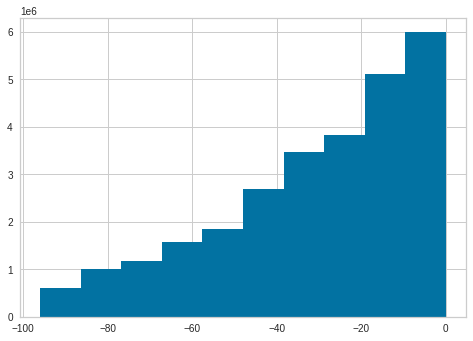

(<matplotlib.axes._subplots.AxesSubplot at 0x7f18da552650>, None)

In [18]:
# Histogram
bureau_balance.MONTHS_BALANCE.hist(), plt.show()

In [19]:
bureau_balance.STATUS.value_counts()

C    13646993
0     7499507
X     5810482
1      242347
5       62406
2       23419
3        8924
4        5847
Name: STATUS, dtype: int64

## Data Manipulation & Feature Engineering for Bureau Balance

In [20]:
# One-Hot Encoder
bb, bb_cat = one_hot_encoder(bureau_balance, nan_as_category=False)
bb.head()

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS_0,STATUS_1,STATUS_2,STATUS_3,STATUS_4,STATUS_5,STATUS_C,STATUS_X
0,5715448,0,0,0,0,0,0,0,1,0
1,5715448,-1,0,0,0,0,0,0,1,0
2,5715448,-2,0,0,0,0,0,0,1,0
3,5715448,-3,0,0,0,0,0,0,1,0
4,5715448,-4,0,0,0,0,0,0,1,0


In [21]:
# Bureau balance: Perform aggregations and merge with bureau.csv
bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}

In [22]:
for col in bb_cat:
    bb_aggregations[col] = ['mean']
bb_aggregations

{'MONTHS_BALANCE': ['min', 'max', 'size'],
 'STATUS_0': ['mean'],
 'STATUS_1': ['mean'],
 'STATUS_2': ['mean'],
 'STATUS_3': ['mean'],
 'STATUS_4': ['mean'],
 'STATUS_5': ['mean'],
 'STATUS_C': ['mean'],
 'STATUS_X': ['mean']}

In [23]:
bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
bb_agg.shape

(817395, 11)

In [24]:
bb_agg.head(3)

MONTHS_BALANCE          STATUS_0 STATUS_1 STATUS_2 STATUS_3  \
                        min max size     mean     mean     mean     mean   
SK_ID_BUREAU                                                               
5001709                 -96   0   97     0.00     0.00     0.00     0.00   
5001710                 -82   0   83     0.06     0.00     0.00     0.00   
5001711                  -3   0    4     0.75     0.00     0.00     0.00   

             STATUS_4 STATUS_5 STATUS_C STATUS_X  
                 mean     mean     mean     mean  
SK_ID_BUREAU                                      
5001709          0.00     0.00     0.89     0.11  
5001710          0.00     0.00     0.58     0.36  
5001711          0.00     0.00     0.00     0.25

In [25]:
bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])
bb_agg.columns

Index(['MONTHS_BALANCE_MIN', 'MONTHS_BALANCE_MAX', 'MONTHS_BALANCE_SIZE',
       'STATUS_0_MEAN', 'STATUS_1_MEAN', 'STATUS_2_MEAN', 'STATUS_3_MEAN',
       'STATUS_4_MEAN', 'STATUS_5_MEAN', 'STATUS_C_MEAN', 'STATUS_X_MEAN'],
      dtype='object')

In [26]:
bb_agg.head(3)

,MONTHS_BALANCE_MIN,MONTHS_BALANCE_MAX,MONTHS_BALANCE_SIZE,STATUS_0_MEAN,STATUS_1_MEAN,STATUS_2_MEAN,STATUS_3_MEAN,STATUS_4_MEAN,STATUS_5_MEAN,STATUS_C_MEAN,STATUS_X_MEAN
SK_ID_BUREAU,,,,,,,,,,,
5001709,-96,0,97,0.00,0.00,0.00,0.00,0.00,0.00,0.89,0.11
5001710,-82,0,83,0.06,0.00,0.00,0.00,0.00,0.00,0.58,0.36
5001711,-3,0,4,0.75,0.00,0.00,0.00,0.00,0.00,0.00,0.25


In [27]:
# Status Sum
bb_agg["STATUS_C0_MEAN_SUM"] = bb_agg[["STATUS_C_MEAN",
                                       "STATUS_0_MEAN"]].sum(axis = 1)

bb_agg["STATUS_12_MEAN_SUM"] = bb_agg[["STATUS_1_MEAN",
                                       "STATUS_2_MEAN"]].sum(axis = 1)

bb_agg["STATUS_345_MEAN_SUM"] = bb_agg[["STATUS_3_MEAN",
                                        "STATUS_4_MEAN",
                                        "STATUS_5_MEAN"]].sum(axis = 1)

bb_agg["STATUS_12345_MEAN_SUM"] = bb_agg[["STATUS_1_MEAN",
                                          "STATUS_2_MEAN",
                                          "STATUS_3_MEAN",
                                          "STATUS_4_MEAN",
                                          "STATUS_5_MEAN"]].sum(axis = 1)

In [28]:
# Find the first month when the credit is closed!
closed = bureau_balance[bureau_balance.STATUS == "C"]
closed = closed.groupby("SK_ID_BUREAU").MONTHS_BALANCE.min().reset_index().rename({"MONTHS_BALANCE":"MONTHS_BALANCE_FIRST_C"}, axis = 1)
closed.shape

(449604, 2)

In [29]:
closed.head(3)

,SK_ID_BUREAU,MONTHS_BALANCE_FIRST_C
0,5001709,-85
1,5001710,-47
2,5001712,-8


In [30]:
# One-Hot Encoder
bb, bb_cat = one_hot_encoder(bureau_balance, nan_as_category=False)

# Bureau balance: Perform aggregations and merge with bureau.csv
bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}

for col in bb_cat:
    bb_aggregations[col] = ['mean']

bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])

# Status Sum
bb_agg["STATUS_C0_MEAN_SUM"] = bb_agg[["STATUS_C_MEAN",
                                       "STATUS_0_MEAN"]].sum(axis = 1)
bb_agg["STATUS_12_MEAN_SUM"] = bb_agg[["STATUS_1_MEAN",
                                       "STATUS_2_MEAN"]].sum(axis = 1)
bb_agg["STATUS_345_MEAN_SUM"] = bb_agg[["STATUS_3_MEAN",
                                        "STATUS_4_MEAN",
                                        "STATUS_5_MEAN"]].sum(axis = 1)
bb_agg["STATUS_12345_MEAN_SUM"] = bb_agg[["STATUS_1_MEAN",
                                          "STATUS_2_MEAN",
                                          "STATUS_3_MEAN",
                                          "STATUS_4_MEAN",
                                          "STATUS_5_MEAN"]].sum(axis = 1)

# Find the first month when the credit is closed!
closed = bureau_balance[bureau_balance.STATUS == "C"]
closed = closed.groupby("SK_ID_BUREAU").MONTHS_BALANCE.min().reset_index().rename({"MONTHS_BALANCE":"MONTHS_BALANCE_FIRST_C"}, axis = 1)
closed["MONTHS_BALANCE_FIRST_C"] = np.abs(closed["MONTHS_BALANCE_FIRST_C"])
bb_agg = pd.merge(bb_agg, closed, how = "left", on = "SK_ID_BUREAU")
bb_agg["MONTHS_BALANCE_CLOSED_DIF"] = np.abs(bb_agg.MONTHS_BALANCE_MIN) - bb_agg.MONTHS_BALANCE_FIRST_C

del closed, bb_aggregations, bureau_balance, bb_cat

In [31]:
print("BURAU BALANCE SHAPE:", bb_agg.shape, "\n")

bb_agg.head()

BURAU BALANCE SHAPE: (817395, 18) 



,SK_ID_BUREAU,MONTHS_BALANCE_MIN,MONTHS_BALANCE_MAX,MONTHS_BALANCE_SIZE,STATUS_0_MEAN,STATUS_1_MEAN,STATUS_2_MEAN,STATUS_3_MEAN,STATUS_4_MEAN,STATUS_5_MEAN,STATUS_C_MEAN,STATUS_X_MEAN,STATUS_C0_MEAN_SUM,STATUS_12_MEAN_SUM,STATUS_345_MEAN_SUM,STATUS_12345_MEAN_SUM,MONTHS_BALANCE_FIRST_C,MONTHS_BALANCE_CLOSED_DIF
0,5001709,-96,0,97,0.00,0.00,0.00,0.00,0.00,0.00,0.89,0.11,0.89,0.00,0.00,0.00,85.00,11.00
1,5001710,-82,0,83,0.06,0.00,0.00,0.00,0.00,0.00,0.58,0.36,0.64,0.00,0.00,0.00,47.00,35.00
2,5001711,-3,0,4,0.75,0.00,0.00,0.00,0.00,0.00,0.00,0.25,0.75,0.00,0.00,0.00,nan,nan
3,5001712,-18,0,19,0.53,0.00,0.00,0.00,0.00,0.00,0.47,0.00,1.00,0.00,0.00,0.00,8.00,10.00
4,5001713,-21,0,22,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,nan,nan


# 3. Bureau

1. Tous les crédits précédents du client fournis par d'autres institutions financières qui ont été signalés au bureau de crédit 

2. Pour chaque prêt de notre échantillon, il y a autant de lignes que le nombre de crédits que le client avait dans le bureau de crédit 

In [32]:
bureau = pd.read_csv("/content/drive/MyDrive/OC/Projet 7/data/bureau.csv")
bureau = reduce_mem_usage(bureau)

print(bureau.shape, "\n")

bureau.head()

Memory usage of dataframe is 222.62 MB
Memory usage after optimization is: 78.57 MB
Decreased by 64.7%
(1716428, 17) 



,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.00,-153.00,nan,0,"91,323.00",0.00,nan,0.00,Consumer credit,-131,nan
1,215354,5714463,Active,currency 1,-208,0,"1,075.00",nan,nan,0,"225,000.00","171,342.00",nan,0.00,Credit card,-20,nan
2,215354,5714464,Active,currency 1,-203,0,528.00,nan,nan,0,"464,323.50",nan,nan,0.00,Consumer credit,-16,nan
3,215354,5714465,Active,currency 1,-203,0,nan,nan,nan,0,"90,000.00",nan,nan,0.00,Credit card,-16,nan
4,215354,5714466,Active,currency 1,-629,0,"1,197.00",nan,"77,674.50",0,"2,700,000.00",nan,nan,0.00,Consumer credit,-21,nan


In [33]:
bureau.sample(5)

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
970863,389487,5877447,Closed,currency 1,-1230,0,-559.00,-559.00,0.00,0,"138,185.95",0.00,0.00,0.00,Consumer credit,-553,0.00
724909,291657,5024876,Closed,currency 1,-779,0,682.00,-349.00,nan,0,"1,910,830.50",0.00,0.00,0.00,Consumer credit,-48,"21,150.00"
921160,438227,5072501,Active,currency 1,-621,0,768.00,nan,nan,0,"157,500.00","147,186.00",0.00,0.00,Credit card,-16,nan
1660950,427149,6646334,Closed,currency 1,-484,0,"10,416.00",-447.00,0.00,0,"45,000.00",nan,nan,0.00,Credit card,-447,nan
1021962,257139,5923653,Closed,currency 1,-1765,0,"-1,582.00","-1,578.00",nan,0,"20,416.50",0.00,nan,0.00,Consumer credit,-1229,nan


## Merge Bureau Balance and Bureau

In [34]:
# LEFT JOIN WITH BUREAU
bureau = pd.merge(bureau, bb_agg, how='left', on='SK_ID_BUREAU')
del bb_agg

print(bureau.shape, "\n")

(1716428, 34) 



## EDA for Bureau

Exploration des valeurs manqueantes.

In [35]:
# Are there any missing values in the data?
missing_values(bureau, plot = False)

Number of Variables include Missing Values: 24 

                      Feature  Num_Missing  Missing_Ratio DataTypes
0   MONTHS_BALANCE_CLOSED_DIF      1299036           0.76   float64
1      MONTHS_BALANCE_FIRST_C      1299036           0.76   float64
2                 AMT_ANNUITY      1226791           0.71   float32
3      AMT_CREDIT_MAX_OVERDUE      1124488           0.66   float32
4               STATUS_5_MEAN       942074           0.55   float64
5               STATUS_0_MEAN       942074           0.55   float64
6               STATUS_1_MEAN       942074           0.55   float64
7               STATUS_2_MEAN       942074           0.55   float64
8               STATUS_3_MEAN       942074           0.55   float64
9               STATUS_4_MEAN       942074           0.55   float64
10              STATUS_C_MEAN       942074           0.55   float64
11         MONTHS_BALANCE_MAX       942074           0.55   float64
12              STATUS_X_MEAN       942074           0.55   float64

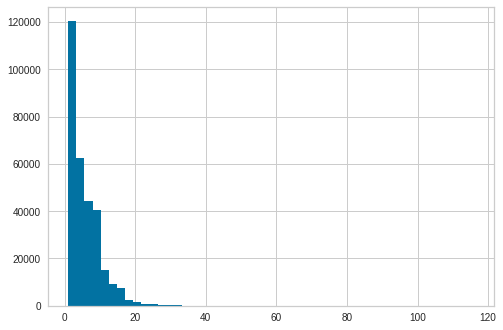

max      116.00
mean       5.61
min        1.00
median     4.00
std        4.43
Name: SK_ID_BUREAU, dtype: float64

In [36]:
# How many loans of each customer are there to from Credit Bureau?

bureau.groupby("SK_ID_CURR").SK_ID_BUREAU.count().hist(bins=50), plt.show()
bureau.groupby("SK_ID_CURR").SK_ID_BUREAU.count().agg({"min", "max", "mean", "median", "std"})


**grab_col_names** est une fonction super utiles pour me comprendre les données. Elle permet d'afficher combien il existe de datetime, variables catégorique et numérique. Par exemple, Il peut y avoir des colonnes qui sont supposé d'être numérique mais qui sont considéré comme catégoriques. Donc grab_col_names nous permet de comprendre profondément les données.

In [37]:
# Columns
cat_cols, cat_but_car, num_cols, num_but_cat = grab_col_names(bureau, car_th=10)

print("")

# Categorical Features
print(cat_cols, cat_but_car)

Observations: 1716428
Variables: 34
date_cols: 0
cat_cols: 2
num_cols: 23
cat_but_car: 1
num_but_cat: 0

['CREDIT_ACTIVE', 'CREDIT_CURRENCY'] ['CREDIT_TYPE']


La fonction **cat_analyzer** nous donne le nombre de valeurs et le ratio des catégories dans une colonne. Nous pouvons déterminer les catégories ou colonnes peuvent être plus importantes que d'autres. De plus, cat_analyzer nous indique quelles colonnes incluent des catégorie rare. Dans le cas  des catégories rares dans une colonne, nous pouvons utiliser la fonction **Rare Encoder** pour combiner différentes catégories rares. L'objectif principal de Rare Encoder est de réduire le nombre de catégories dans une colonne afin que la colonne puisse être plus utile pour la modélisation.

In [38]:
# Cat Analyzer
for i in cat_cols + cat_but_car:
    cat_analyzer(bureau, i)

CREDIT_ACTIVE
            COUNT  RATIO
Closed    1079273   0.63
Active     630607   0.37
Sold         6527   0.00
Bad debt       21   0.00


CREDIT_CURRENCY
              COUNT  RATIO
currency 1  1715020   1.00
currency 2     1224   0.00
currency 3      174   0.00
currency 4       10   0.00


CREDIT_TYPE
                                                COUNT  RATIO
Consumer credit                               1251615   0.73
Credit card                                    402195   0.23
Car loan                                        27690   0.02
Mortgage                                        18391   0.01
Microloan                                       12413   0.01
Loan for business development                    1975   0.00
Another type of loan                             1017   0.00
Unknown type of loan                              555   0.00
Loan for working capital replenishment            469   0.00
Cash loan (non-earmarked)                          56   0.00
Real estate loan       

Après les résultats de cat_analyzer :

- Je pense que la variable CREDIT_CURRENCY est inutile pour la modélisation. Presque toutes les lignes appartiennent à la catégorie de devise 1.

- La variable CREDIT_ACTIVE peut être utile. Il y a deux catégories rares dans cette colonne. Nous pouvons combiner ces deux catégories afin d'attribuer une nouvelle catégorie en tant que Sold_BadDebt. La variable CREDIT_ACTIVE comprend 3 catégories : Actif, Fermé et Sold_BadDebt.

- CREDIT_TYPE peut être utile, mais il existe également des catégories rares. Nous devrions réduire le nombre de catégories.


In [39]:
# Numeric Features
bureau.drop(["SK_ID_CURR" ,"SK_ID_BUREAU"], axis = 1).describe([.01, .1, .25, .5, .75, .8, .9, .95, .99])[1:]


,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,DAYS_CREDIT_UPDATE,AMT_ANNUITY,MONTHS_BALANCE_MIN,MONTHS_BALANCE_MAX,MONTHS_BALANCE_SIZE,STATUS_0_MEAN,STATUS_1_MEAN,STATUS_2_MEAN,STATUS_3_MEAN,STATUS_4_MEAN,STATUS_5_MEAN,STATUS_C_MEAN,STATUS_X_MEAN,STATUS_C0_MEAN_SUM,STATUS_12_MEAN_SUM,STATUS_345_MEAN_SUM,STATUS_12345_MEAN_SUM,MONTHS_BALANCE_FIRST_C,MONTHS_BALANCE_CLOSED_DIF
mean,"-1,142.11",0.82,nan,nan,"3,825.36",0.01,"354,577.31","137,081.83","6,229.78",37.91,-593.75,"15,713.27",-36.29,-6.06,31.23,0.41,0.01,0.00,0.00,0.00,0.00,0.36,0.22,0.77,0.01,0.00,0.01,31.74,11.76
std,795.16,36.54,nan,nan,"205,987.31",0.10,"1,150,276.62","679,074.88","44,896.66","5,937.52",720.75,"325,655.59",25.45,15.06,23.48,0.35,0.05,0.01,0.00,0.00,0.03,0.37,0.34,0.34,0.05,0.03,0.06,22.91,10.78
min,"-2,922.00",0.00,"-42,048.00","-42,016.00",0.00,0.00,0.00,"-4,705,600.50","-586,406.12",0.00,"-41,947.00",0.00,-96.00,-95.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1%,"-2,867.00",0.00,"-2,572.00","-2,640.00",0.00,0.00,0.00,0.00,0.00,0.00,"-2,531.00",0.00,-93.00,-72.00,2.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
10%,"-2,443.00",0.00,"-1,922.00","-2,160.00",0.00,0.00,"22,500.00",0.00,0.00,0.00,"-1,561.00",0.00,-78.00,-25.00,6.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,5.00,3.00
25%,"-1,666.00",0.00,"-1,138.00","-1,489.00",0.00,0.00,"51,300.00",0.00,0.00,0.00,-908.00,0.00,-53.00,0.00,12.00,0.10,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.67,0.00,0.00,0.00,13.00,5.00
50%,-987.00,0.00,-330.00,-897.00,0.00,0.00,"125,518.50",0.00,0.00,0.00,-395.00,0.00,-31.00,0.00,25.00,0.33,0.00,0.00,0.00,0.00,0.00,0.24,0.03,0.95,0.00,0.00,0.00,28.00,9.00
75%,-474.00,0.00,474.00,-425.00,0.00,0.00,"315,000.00","40,153.50",0.00,0.00,-33.00,"13,500.00",-15.00,0.00,45.00,0.73,0.00,0.00,0.00,0.00,0.00,0.74,0.31,1.00,0.00,0.00,0.00,46.00,13.00
80%,-385.00,0.00,725.00,-340.00,45.00,0.00,"423,000.00","90,009.00",0.00,0.00,-25.00,"17,660.21",-12.00,0.00,50.00,0.83,0.00,0.00,0.00,0.00,0.00,0.80,0.44,1.00,0.00,0.00,0.00,52.00,17.00
90%,-215.00,0.00,"1,334.00",-178.00,"7,594.88",0.00,"778,754.75","295,456.50",0.00,0.00,-13.00,"31,432.50",-7.00,0.00,67.00,0.97,0.02,0.00,0.00,0.00,0.00,0.88,1.00,1.00,0.03,0.00,0.03,68.00,24.00


Le table ci-dessus nous montre donne des observations importantes et nous permet de distinguer/repérer les valeurs abbérantes. Par example, dans la colonne AMT_CREDIT_MAX_OVERDUE, la valeur maximale est de 115 987 tant dis que 99% percentile est de 41 988. Ceci est une différence considérable.

In [40]:
# Quick Visualization for numerical variables
# num_plot(bureau, num_cols=num_cols, remove=['SK_ID_CURR','SK_ID_BUREAU'], figsize = (15,3))

In [41]:
# Correlation
# corr_plot(bureau, remove=['SK_ID_CURR','SK_ID_BUREAU'], corr_coef = "spearman")

In [42]:
# high_correlation(bureau, remove=['SK_ID_CURR','SK_ID_BUREAU'], corr_coef = "spearman", corr_value = 0.7)

## Data Manipulation & Feature Engineering for Bureau

In [43]:
# FEATURE ENGINEERING FOR BUREAU

# Categorical Variables
# -----------------------------------------------------------
# Useless
bureau.drop("CREDIT_CURRENCY", axis = 1, inplace = True)

# Rare Categories
bureau["CREDIT_ACTIVE"] = np.where(bureau.CREDIT_ACTIVE.isin(["Sold", "Bad debt"]), "Sold_BadDebt",
                                   bureau.CREDIT_ACTIVE)

bureau["CREDIT_TYPE"] = np.where(
    ~bureau.CREDIT_TYPE.isin(
        ["Consumer credit", "Credit card", "Car loan", "Mortgage", "Microloan"]
    ), "Other", bureau["CREDIT_TYPE"])

# One-Hot Encoder
bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category=False)


# Numerical Variables
# -----------------------------------------------------------

# Bureau and bureau_balance numeric features
cal = ['min', 'max', 'mean', 'sum', 'median','std']
cols1 = [
    'DAYS_CREDIT', 'DAYS_CREDIT_ENDDATE', 'DAYS_CREDIT_UPDATE','CREDIT_DAY_OVERDUE',
    'AMT_CREDIT_MAX_OVERDUE', 'AMT_CREDIT_SUM', 'AMT_CREDIT_SUM_DEBT', 'AMT_CREDIT_SUM_OVERDUE',
    'AMT_CREDIT_SUM_LIMIT', 'AMT_ANNUITY', 'CNT_CREDIT_PROLONG', 'MONTHS_BALANCE_MIN',
    'MONTHS_BALANCE_MAX', 'MONTHS_BALANCE_SIZE', 'MONTHS_BALANCE_FIRST_C', 'MONTHS_BALANCE_CLOSED_DIF'
]

num_aggregations = {}


for i in cols1:
    num_aggregations[i] = cal
    
    
# Bureau and bureau_balance categorical features
cat_aggregations = {}

for i in bureau_cat:
    cat_aggregations[i] = ['mean']

cols2 = ['STATUS_0_MEAN', 'STATUS_1_MEAN', 'STATUS_2_MEAN', 'STATUS_3_MEAN', 'STATUS_4_MEAN',
        'STATUS_5_MEAN', 'STATUS_C_MEAN', 'STATUS_X_MEAN', 'STATUS_C0_MEAN_SUM',
        'STATUS_12_MEAN_SUM', 'STATUS_345_MEAN_SUM', 'STATUS_12345_MEAN_SUM']
for i in cols2:
    cat_aggregations[i] = ['mean', 'median', 'sum', 'max', 'std']

del i, cols1, cols2, bureau_cat, cal
    
# Create aggregated data
bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
bureau_agg.columns = pd.Index(['BUREAU_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])


# New features
bureau.groupby("SK_ID_CURR").SK_ID_BUREAU.count().value_counts()
bcount = bureau.groupby("SK_ID_CURR").SK_ID_BUREAU.count().reset_index().rename({"SK_ID_BUREAU":"BUREAU_COUNT"},
                                                                                axis = 1)
bcount["BUREAU_COUNT_CAT"] = np.where(bcount.BUREAU_COUNT < 4, 0, 1)
bcount["BUREAU_COUNT_CAT"] = np.where((bcount.BUREAU_COUNT >= 8) & (bcount.BUREAU_COUNT < 13), 2,
                                      bcount["BUREAU_COUNT_CAT"])
bcount["BUREAU_COUNT_CAT"] = np.where((bcount.BUREAU_COUNT >= 13) & (bcount.BUREAU_COUNT < 20), 3,
                                      bcount["BUREAU_COUNT_CAT"])
bcount["BUREAU_COUNT_CAT"] = np.where((bcount.BUREAU_COUNT >= 20), 4, bcount["BUREAU_COUNT_CAT"])
bureau_agg = pd.merge(bureau_agg, bcount, how = "left", on = "SK_ID_CURR")
del bcount


# Bureau: Active credits - using only numerical aggregations
active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
bureau_agg = pd.merge(bureau_agg, active_agg, how='left', on='SK_ID_CURR')
del active, active_agg


# Bureau: Closed credits - using only numerical aggregations
closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
bureau_agg = pd.merge(bureau_agg, closed_agg, how='left', on='SK_ID_CURR')
del closed, closed_agg

# Bureau: Sold and Bad Debt credits - using only numerical aggregations
sold_baddebt = bureau[bureau['CREDIT_ACTIVE_Sold_BadDebt'] == 1]
sold_baddebt_agg = sold_baddebt.groupby('SK_ID_CURR').agg(num_aggregations)
sold_baddebt_agg.columns = pd.Index(['SOLD_BADDEBT' + e[0] + "_" + e[1].upper() for e in sold_baddebt_agg.columns.tolist()])
bureau_agg = pd.merge(bureau_agg, sold_baddebt_agg, how='left', on='SK_ID_CURR')
del sold_baddebt, sold_baddebt_agg, bureau

del num_aggregations, cat_aggregations


# WRITE FEATHER
bureau_agg.to_feather(source_path +"bureau_bureaubalance_agg_feather")
#pd.read_feather("./bureau_bureaubalance_agg_feather")

print("BUREAU & BUREAU BALANCE SHAPE:", bureau_agg.shape, "\n")

bureau_agg.head()

BUREAU & BUREAU BALANCE SHAPE: (305811, 456) 



,SK_ID_CURR,BUREAU_DAYS_CREDIT_MIN,BUREAU_DAYS_CREDIT_MAX,BUREAU_DAYS_CREDIT_MEAN,BUREAU_DAYS_CREDIT_SUM,BUREAU_DAYS_CREDIT_MEDIAN,BUREAU_DAYS_CREDIT_STD,BUREAU_DAYS_CREDIT_ENDDATE_MIN,BUREAU_DAYS_CREDIT_ENDDATE_MAX,BUREAU_DAYS_CREDIT_ENDDATE_MEAN,BUREAU_DAYS_CREDIT_ENDDATE_SUM,BUREAU_DAYS_CREDIT_ENDDATE_MEDIAN,BUREAU_DAYS_CREDIT_ENDDATE_STD,BUREAU_DAYS_CREDIT_UPDATE_MIN,BUREAU_DAYS_CREDIT_UPDATE_MAX,BUREAU_DAYS_CREDIT_UPDATE_MEAN,BUREAU_DAYS_CREDIT_UPDATE_SUM,BUREAU_DAYS_CREDIT_UPDATE_MEDIAN,BUREAU_DAYS_CREDIT_UPDATE_STD,BUREAU_CREDIT_DAY_OVERDUE_MIN,BUREAU_CREDIT_DAY_OVERDUE_MAX,BUREAU_CREDIT_DAY_OVERDUE_MEAN,BUREAU_CREDIT_DAY_OVERDUE_SUM,BUREAU_CREDIT_DAY_OVERDUE_MEDIAN,BUREAU_CREDIT_DAY_OVERDUE_STD,BUREAU_AMT_CREDIT_MAX_OVERDUE_MIN,BUREAU_AMT_CREDIT_MAX_OVERDUE_MAX,BUREAU_AMT_CREDIT_MAX_OVERDUE_MEAN,BUREAU_AMT_CREDIT_MAX_OVERDUE_SUM,BUREAU_AMT_CREDIT_MAX_OVERDUE_MEDIAN,BUREAU_AMT_CREDIT_MAX_OVERDUE_STD,BUREAU_AMT_CREDIT_SUM_MIN,BUREAU_AMT_CREDIT_SUM_MAX,BUREAU_AMT_CREDIT_SUM_MEAN,BUREAU_AMT_CREDIT_SUM_SUM,BUREAU_AMT_CREDIT_SUM_MEDIAN,BUREAU_AMT_CREDIT_SUM_STD,BUREAU_AMT_CREDIT_SUM_DEBT_MIN,BUREAU_AMT_CREDIT_SUM_DEBT_MAX,BUREAU_AMT_CREDIT_SUM_DEBT_MEAN,BUREAU_AMT_CREDIT_SUM_DEBT_SUM,BUREAU_AMT_CREDIT_SUM_DEBT_MEDIAN,BUREAU_AMT_CREDIT_SUM_DEBT_STD,BUREAU_AMT_CREDIT_SUM_OVERDUE_MIN,BUREAU_AMT_CREDIT_SUM_OVERDUE_MAX,BUREAU_AMT_CREDIT_SUM_OVERDUE_MEAN,BUREAU_AMT_CREDIT_SUM_OVERDUE_SUM,BUREAU_AMT_CREDIT_SUM_OVERDUE_MEDIAN,BUREAU_AMT_CREDIT_SUM_OVERDUE_STD,BUREAU_AMT_CREDIT_SUM_LIMIT_MIN,BUREAU_AMT_CREDIT_SUM_LIMIT_MAX,BUREAU_AMT_CREDIT_SUM_LIMIT_MEAN,BUREAU_AMT_CREDIT_SUM_LIMIT_SUM,BUREAU_AMT_CREDIT_SUM_LIMIT_MEDIAN,BUREAU_AMT_CREDIT_SUM_LIMIT_STD,BUREAU_AMT_ANNUITY_MIN,BUREAU_AMT_ANNUITY_MAX,BUREAU_AMT_ANNUITY_MEAN,BUREAU_AMT_ANNUITY_SUM,BUREAU_AMT_ANNUITY_MEDIAN,BUREAU_AMT_ANNUITY_STD,BUREAU_CNT_CREDIT_PROLONG_MIN,BUREAU_CNT_CREDIT_PROLONG_MAX,BUREAU_CNT_CREDIT_PROLONG_MEAN,BUREAU_CNT_CREDIT_PROLONG_SUM,BUREAU_CNT_CREDIT_PROLONG_MEDIAN,BUREAU_CNT_CREDIT_PROLONG_STD,BUREAU_MONTHS_BALANCE_MIN_MIN,BUREAU_MONTHS_BALANCE_MIN_MAX,BUREAU_MONTHS_BALANCE_MIN_MEAN,BUREAU_MONTHS_BALANCE_MIN_SUM,BUREAU_MONTHS_BALANCE_MIN_MEDIAN,BUREAU_MONTHS_BALANCE_MIN_STD,BUREAU_MONTHS_BALANCE_MAX_MIN,BUREAU_MONTHS_BALANCE_MAX_MAX,BUREAU_MONTHS_BALANCE_MAX_MEAN,BUREAU_MONTHS_BALANCE_MAX_SUM,BUREAU_MONTHS_BALANCE_MAX_MEDIAN,BUREAU_MONTHS_BALANCE_MAX_STD,BUREAU_MONTHS_BALANCE_SIZE_MIN,BUREAU_MONTHS_BALANCE_SIZE_MAX,BUREAU_MONTHS_BALANCE_SIZE_MEAN,BUREAU_MONTHS_BALANCE_SIZE_SUM,BUREAU_MONTHS_BALANCE_SIZE_MEDIAN,BUREAU_MONTHS_BALANCE_SIZE_STD,BUREAU_MONTHS_BALANCE_FIRST_C_MIN,BUREAU_MONTHS_BALANCE_FIRST_C_MAX,BUREAU_MONTHS_BALANCE_FIRST_C_MEAN,BUREAU_MONTHS_BALANCE_FIRST_C_SUM,BUREAU_MONTHS_BALANCE_FIRST_C_MEDIAN,BUREAU_MONTHS_BALANCE_FIRST_C_STD,BUREAU_MONTHS_BALANCE_CLOSED_DIF_MIN,BUREAU_MONTHS_BALANCE_CLOSED_DIF_MAX,BUREAU_MONTHS_BALANCE_CLOSED_DIF_MEAN,BUREAU_MONTHS_BALANCE_CLOSED_DIF_SUM,BUREAU_MONTHS_BALANCE_CLOSED_DIF_MEDIAN,BUREAU_MONTHS_BALANCE_CLOSED_DIF_STD,BUREAU_CREDIT_ACTIVE_Active_MEAN,BUREAU_CREDIT_ACTIVE_Closed_MEAN,BUREAU_CREDIT_ACTIVE_Sold_BadDebt_MEAN,BUREAU_CREDIT_TYPE_Car loan_MEAN,BUREAU_CREDIT_TYPE_Consumer credit_MEAN,BUREAU_CREDIT_TYPE_Credit card_MEAN,BUREAU_CREDIT_TYPE_Microloan_MEAN,BUREAU_CREDIT_TYPE_Mortgage_MEAN,BUREAU_CREDIT_TYPE_Other_MEAN,BUREAU_STATUS_0_MEAN_MEAN,BUREAU_STATUS_0_MEAN_MEDIAN,BUREAU_STATUS_0_MEAN_SUM,BUREAU_STATUS_0_MEAN_MAX,BUREAU_STATUS_0_MEAN_STD,BUREAU_STATUS_1_MEAN_MEAN,BUREAU_STATUS_1_MEAN_MEDIAN,BUREAU_STATUS_1_MEAN_SUM,BUREAU_STATUS_1_MEAN_MAX,BUREAU_STATUS_1_MEAN_STD,BUREAU_STATUS_2_MEAN_MEAN,BUREAU_STATUS_2_MEAN_MEDIAN,BUREAU_STATUS_2_MEAN_SUM,BUREAU_STATUS_2_MEAN_MAX,BUREAU_STATUS_2_MEAN_STD,BUREAU_STATUS_3_MEAN_MEAN,BUREAU_STATUS_3_MEAN_MEDIAN,BUREAU_STATUS_3_MEAN_SUM,BUREAU_STATUS_3_MEAN_MAX,BUREAU_STATUS_3_MEAN_STD,BUREAU_STATUS_4_MEAN_MEAN,BUREAU_STATUS_4_MEAN_MEDIAN,BUREAU_STATUS_4_MEAN_SUM,BUREAU_STATUS_4_MEAN_MAX,BUREAU_STATUS_4_MEAN_STD,BUREAU_STATUS_5_MEAN_MEAN,BUREAU_STATUS_5_MEAN_MEDIA

In [44]:
bureau_agg.to_feather(source_path + "bureau_bureaubalance_agg_feather")
del bureau_agg

# 4. Pos Cash Balance

In [45]:
pos = pd.read_csv('/content/drive/MyDrive/OC/Projet 7/data/POS_CASH_balance.csv')
pos = reduce_mem_usage(pos)

print(pos.shape, "\n")

# Columns
cat_cols, cat_but_car, num_cols, num_but_cat = grab_col_names(pos, car_th=10)

print("")

pos.head()

Memory usage of dataframe is 610.43 MB
Memory usage after optimization is: 171.69 MB
Decreased by 71.9%
(10001358, 8) 

Observations: 10001358
Variables: 8
date_cols: 0
cat_cols: 1
num_cols: 5
cat_but_car: 0
num_but_cat: 0



,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.00,45.00,Active,0,0
1,1715348,367990,-33,36.00,35.00,Active,0,0
2,1784872,397406,-32,12.00,9.00,Active,0,0
3,1903291,269225,-35,48.00,42.00,Active,0,0
4,2341044,334279,-35,36.00,35.00,Active,0,0


## EDA for Pos Cash Balance

In [46]:
# missing values
missing_values(pos, plot = False)

Number of Variables include Missing Values: 2 

                 Feature  Num_Missing  Missing_Ratio DataTypes
0  CNT_INSTALMENT_FUTURE        26087           0.00   float16
1         CNT_INSTALMENT        26071           0.00   float16 



In [47]:
# Cat Analyzer
cat_analyzer(pos, "NAME_CONTRACT_STATUS")

NAME_CONTRACT_STATUS
                         COUNT  RATIO
Active                 9151119   0.91
Completed               744883   0.07
Signed                   87260   0.01
Demand                    7065   0.00
Returned to the store     5461   0.00
Approved                  4917   0.00
Amortized debt             636   0.00
Canceled                    15   0.00
XNA                          2   0.00




In [48]:
# Numeric Features
pos.drop(["SK_ID_CURR" ,"SK_ID_PREV"], axis = 1).describe([.01, .1, .25, .5, .75, .8, .9, .95, .99])[1:]

,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,SK_DPD,SK_DPD_DEF
mean,-35.01,nan,nan,11.61,0.65
std,26.07,0.00,0.00,132.71,32.76
min,-96.00,1.00,0.00,0.00,0.00
1%,-94.00,4.00,0.00,0.00,0.00
10%,-77.00,6.00,0.00,0.00,0.00
25%,-54.00,10.00,3.00,0.00,0.00
50%,-28.00,12.00,7.00,0.00,0.00
75%,-13.00,24.00,14.00,0.00,0.00
80%,-11.00,24.00,17.00,0.00,0.00
90%,-6.00,36.00,24.00,0.00,0.00


In [49]:
# Quick Visualization for numerical variables
# num_plot(pos, num_cols=num_cols, remove=['SK_ID_CURR','SK_ID_PREV'], figsize = (15,3))

In [50]:
# Correlation
# corr_plot(pos, remove=['SK_ID_CURR','SK_ID_PREV'], corr_coef = "spearman", figsize = (5,5))

## Data Manipulation & Feature Engineering for Pos Cash Balance


In [51]:
# Rare
pos["NAME_CONTRACT_STATUS"] = np.where(~(pos["NAME_CONTRACT_STATUS"].isin([
   "Active", "Completed"
])), "Rare", pos["NAME_CONTRACT_STATUS"])

# One-Hot Encoder
pos, cat_cols = one_hot_encoder(pos, nan_as_category=False)

aggregations = {
    # Numerical
    'MONTHS_BALANCE': ['max', 'mean', 'size'],
    'CNT_INSTALMENT': ['max', 'mean', 'std', 'min', 'median'],
    'CNT_INSTALMENT_FUTURE': ['max', 'mean', 'sum', 'min', 'median', 'std'],
    'SK_DPD': ['max', 'mean'],
    'SK_DPD_DEF': ['max', 'mean']
}
# Categorical
for cat in cat_cols:
    aggregations[cat] = ['mean']

# Aggregation
pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
# Count pos cash accounts
pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()
pos_agg.reset_index(inplace = True)
del pos

print("POS CASH BALANCE SHAPE:", pos_agg.shape, "\n")

pos_agg.head()

POS CASH BALANCE SHAPE: (337252, 23) 



,SK_ID_CURR,POS_MONTHS_BALANCE_MAX,POS_MONTHS_BALANCE_MEAN,POS_MONTHS_BALANCE_SIZE,POS_CNT_INSTALMENT_MAX,POS_CNT_INSTALMENT_MEAN,POS_CNT_INSTALMENT_STD,POS_CNT_INSTALMENT_MIN,POS_CNT_INSTALMENT_MEDIAN,POS_CNT_INSTALMENT_FUTURE_MAX,POS_CNT_INSTALMENT_FUTURE_MEAN,POS_CNT_INSTALMENT_FUTURE_SUM,POS_CNT_INSTALMENT_FUTURE_MIN,POS_CNT_INSTALMENT_FUTURE_MEDIAN,POS_CNT_INSTALMENT_FUTURE_STD,POS_SK_DPD_MAX,POS_SK_DPD_MEAN,POS_SK_DPD_DEF_MAX,POS_SK_DPD_DEF_MEAN,POS_NAME_CONTRACT_STATUS_Active_MEAN,POS_NAME_CONTRACT_STATUS_Completed_MEAN,POS_NAME_CONTRACT_STATUS_Rare_MEAN,POS_COUNT
0,100001,-53,-72.56,9,4.00,4.00,0.00,4.00,4.00,4.00,1.44,13.00,0.00,1.00,1.42,7,0.78,7,0.78,0.78,0.22,0.00,9
1,100002,-1,-10.00,19,24.00,24.00,0.00,24.00,24.00,24.00,15.00,285.00,6.00,15.00,5.63,0,0.00,0,0.00,1.00,0.00,0.00,19
2,100003,-18,-43.79,28,12.00,10.11,2.81,6.00,12.00,12.00,5.79,162.00,0.00,6.00,3.84,0,0.00,0,0.00,0.93,0.07,0.00,28
3,100004,-24,-25.50,4,4.00,3.75,0.50,3.00,4.00,4.00,2.25,9.00,0.00,2.50,1.71,0,0.00,0,0.00,0.75,0.25,0.00,4
4,100005,-15,-20.00,11,12.00,11.70,0.95,9.00,12.00,12.00,7.20,72.00,0.00,7.50,3.61,0,0.00,0,0.00,0.82,0.09,0.09,11


In [52]:
# WRITE FEATHER
pos_agg.to_feather(source_path + "poscashbalance_agg_feather")
del pos_agg

# 5. Credit Card Balance

In [53]:
cc = pd.read_csv('/content/drive/MyDrive/OC/Projet 7/data/credit_card_balance.csv')
cc = reduce_mem_usage(cc)

print(cc.shape, "\n")

# Columns
cat_cols, cat_but_car, num_cols, num_but_cat = grab_col_names(cc, car_th=10)

print("")

cc.head()

Memory usage of dataframe is 673.88 MB
Memory usage after optimization is: 263.69 MB
Decreased by 60.9%
(3840312, 23) 

Observations: 3840312
Variables: 23
date_cols: 0
cat_cols: 1
num_cols: 7
cat_but_car: 0
num_but_cat: 0



,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,AMT_PAYMENT_CURRENT,AMT_PAYMENT_TOTAL_CURRENT,AMT_RECEIVABLE_PRINCIPAL,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.97,135000,0.00,877.50,0.00,877.50,"1,700.32","1,800.00","1,800.00",0.00,0.00,0.00,0.00,1,0.00,1.00,35.00,Active,0,0
1,2582071,363914,-1,"63,975.55",45000,"2,250.00","2,250.00",0.00,0.00,"2,250.00","2,250.00","2,250.00","60,175.08","64,875.55","64,875.55",1.00,1,0.00,0.00,69.00,Active,0,0
2,1740877,371185,-7,"31,815.22",450000,0.00,0.00,0.00,0.00,"2,250.00","2,250.00","2,250.00","26,926.43","31,460.09","31,460.09",0.00,0,0.00,0.00,30.00,Active,0,0
3,1389973,337855,-4,"236,572.11",225000,"2,250.00","2,250.00",0.00,0.00,"11,795.76","11,925.00","11,925.00","224,949.28","233,048.97","233,048.97",1.00,1,0.00,0.00,10.00,Active,0,0
4,1891521,126868,-1,"453,919.47",450000,0.00,"11,547.00",0.00,"11,547.00","22,924.89","27,000.00","27,000.00","443,044.41","453,919.47","453,919.47",0.00,1,0.00,1.00,101.00,Active,0,0


## EDA for Credit Card Balance

In [54]:
# Are there any missing values in the data?
missing_values(cc, plot = False)

Number of Variables include Missing Values: 9 

                      Feature  Num_Missing  Missing_Ratio DataTypes
0         AMT_PAYMENT_CURRENT       767988           0.20   float32
1    AMT_DRAWINGS_ATM_CURRENT       749816           0.20   float32
2    CNT_DRAWINGS_POS_CURRENT       749816           0.20   float16
3  AMT_DRAWINGS_OTHER_CURRENT       749816           0.20   float32
4    AMT_DRAWINGS_POS_CURRENT       749816           0.20   float32
5  CNT_DRAWINGS_OTHER_CURRENT       749816           0.20   float16
6    CNT_DRAWINGS_ATM_CURRENT       749816           0.20   float16
7   CNT_INSTALMENT_MATURE_CUM       305236           0.08   float16
8     AMT_INST_MIN_REGULARITY       305236           0.08   float32 



In [55]:
# Cat Analyzer
cat_analyzer(cc, "NAME_CONTRACT_STATUS")

NAME_CONTRACT_STATUS
                 COUNT  RATIO
Active         3698436   0.96
Completed       128918   0.03
Signed           11058   0.00
Demand            1365   0.00
Sent proposal      513   0.00
Refused             17   0.00
Approved             5   0.00




In [56]:
# Numeric Features
cc.drop(["SK_ID_CURR" ,"SK_ID_PREV"], axis = 1).describe([.01, .1, .25, .5, .75, .8, .9, .95, .99])[1:]

,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,AMT_PAYMENT_CURRENT,AMT_PAYMENT_TOTAL_CURRENT,AMT_RECEIVABLE_PRINCIPAL,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,SK_DPD,SK_DPD_DEF
mean,-34.52,"58,276.86","153,807.96","5,962.30","7,432.26",288.16,"2,968.84","3,541.78","10,211.03","7,564.77","55,950.36","58,085.02","58,094.59",nan,0.70,0.00,nan,nan,9.28,0.33
std,26.67,"107,464.14","165,145.70","28,033.97","33,366.82","8,197.02","20,663.21","5,525.35","35,791.42","31,594.29","101,517.74","107,176.88","107,180.20",0.00,3.19,0.08,0.00,0.00,97.52,21.48
min,-96.00,"-420,250.19",0.00,"-6,827.31","-6,211.62",0.00,0.00,0.00,0.00,0.00,"-423,305.81","-420,250.19","-420,250.19",0.00,0.00,0.00,0.00,0.00,0.00,0.00
1%,-93.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-487.26,-486.63,0.00,0.00,0.00,0.00,0.00,0.00,0.00
10%,-76.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,-55.00,0.00,"45,000.00",0.00,0.00,0.00,0.00,0.00,152.37,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,4.00,0.00,0.00
50%,-28.00,0.00,"112,500.00",0.00,0.00,0.00,0.00,0.00,"2,702.70",0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,15.00,0.00,0.00
75%,-11.00,"89,046.69","180,000.00",0.00,0.00,0.00,0.00,"6,633.91","9,000.00","6,750.00","85,359.24","88,899.49","88,914.51",0.00,0.00,0.00,0.00,32.00,0.00,0.00
80%,-9.00,"116,880.70","225,000.00",0.00,0.00,0.00,0.00,"7,283.97","10,800.00","9,000.00","111,982.27","116,663.39","116,690.04",0.00,0.00,0.00,0.00,37.00,0.00,0.00
90%,-5.00,"180,016.20","427,500.00","6,750.00","11,250.00",0.00,0.00,"9,000.00","18,900.00","13,500.00","173,228.92","179,815.77","179,830.17",1.00,1.00,0.00,0.00,51.00,0.00,0.00


In [57]:
# Quick Visualization for numerical variables
# num_plot(cc, num_cols=num_cols, remove=['SK_ID_CURR','SK_ID_PREV'], figsize = (15,3))

In [58]:
# Correlation
# corr_plot(cc, remove=['SK_ID_CURR','SK_ID_PREV'], corr_coef = "spearman", figsize = (10,10))

## Data Manipulation & Feature Engineering for Credit Card Balance

In [59]:
# Rare
cc["NAME_CONTRACT_STATUS"] = np.where(~(cc["NAME_CONTRACT_STATUS"].isin([
   "Active", "Completed"
])), "Rare", cc["NAME_CONTRACT_STATUS"])

# One Hot Encoder
cc, cat_cols = one_hot_encoder(cc, nan_as_category=False)

# General aggregations
cc.drop(['SK_ID_PREV'], axis=1, inplace=True)
cc_agg = cc.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', 'std'])
cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
# Count credit card lines
cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()
cc_agg.reset_index(inplace = True)
del cc

print("CREDIT CARD BALANCE SHAPE:", cc_agg.shape, "\n")

cc_agg.head()

CREDIT CARD BALANCE SHAPE: (103558, 117) 



,SK_ID_CURR,CC_MONTHS_BALANCE_MIN,CC_MONTHS_BALANCE_MAX,CC_MONTHS_BALANCE_MEAN,CC_MONTHS_BALANCE_SUM,CC_MONTHS_BALANCE_STD,CC_AMT_BALANCE_MIN,CC_AMT_BALANCE_MAX,CC_AMT_BALANCE_MEAN,CC_AMT_BALANCE_SUM,CC_AMT_BALANCE_STD,CC_AMT_CREDIT_LIMIT_ACTUAL_MIN,CC_AMT_CREDIT_LIMIT_ACTUAL_MAX,CC_AMT_CREDIT_LIMIT_ACTUAL_MEAN,CC_AMT_CREDIT_LIMIT_ACTUAL_SUM,CC_AMT_CREDIT_LIMIT_ACTUAL_STD,CC_AMT_DRAWINGS_ATM_CURRENT_MIN,CC_AMT_DRAWINGS_ATM_CURRENT_MAX,CC_AMT_DRAWINGS_ATM_CURRENT_MEAN,CC_AMT_DRAWINGS_ATM_CURRENT_SUM,CC_AMT_DRAWINGS_ATM_CURRENT_STD,CC_AMT_DRAWINGS_CURRENT_MIN,CC_AMT_DRAWINGS_CURRENT_MAX,CC_AMT_DRAWINGS_CURRENT_MEAN,CC_AMT_DRAWINGS_CURRENT_SUM,CC_AMT_DRAWINGS_CURRENT_STD,CC_AMT_DRAWINGS_OTHER_CURRENT_MIN,CC_AMT_DRAWINGS_OTHER_CURRENT_MAX,CC_AMT_DRAWINGS_OTHER_CURRENT_MEAN,CC_AMT_DRAWINGS_OTHER_CURRENT_SUM,CC_AMT_DRAWINGS_OTHER_CURRENT_STD,CC_AMT_DRAWINGS_POS_CURRENT_MIN,CC_AMT_DRAWINGS_POS_CURRENT_MAX,CC_AMT_DRAWINGS_POS_CURRENT_MEAN,CC_AMT_DRAWINGS_POS_CURRENT_SUM,CC_AMT_DRAWINGS_POS_CURRENT_STD,CC_AMT_INST_MIN_REGULARITY_MIN,CC_AMT_INST_MIN_REGULARITY_MAX,CC_AMT_INST_MIN_REGULARITY_MEAN,CC_AMT_INST_MIN_REGULARITY_SUM,CC_AMT_INST_MIN_REGULARITY_STD,CC_AMT_PAYMENT_CURRENT_MIN,CC_AMT_PAYMENT_CURRENT_MAX,CC_AMT_PAYMENT_CURRENT_MEAN,CC_AMT_PAYMENT_CURRENT_SUM,CC_AMT_PAYMENT_CURRENT_STD,CC_AMT_PAYMENT_TOTAL_CURRENT_MIN,CC_AMT_PAYMENT_TOTAL_CURRENT_MAX,CC_AMT_PAYMENT_TOTAL_CURRENT_MEAN,CC_AMT_PAYMENT_TOTAL_CURRENT_SUM,CC_AMT_PAYMENT_TOTAL_CURRENT_STD,CC_AMT_RECEIVABLE_PRINCIPAL_MIN,CC_AMT_RECEIVABLE_PRINCIPAL_MAX,CC_AMT_RECEIVABLE_PRINCIPAL_MEAN,CC_AMT_RECEIVABLE_PRINCIPAL_SUM,CC_AMT_RECEIVABLE_PRINCIPAL_STD,CC_AMT_RECIVABLE_MIN,CC_AMT_RECIVABLE_MAX,CC_AMT_RECIVABLE_MEAN,CC_AMT_RECIVABLE_SUM,CC_AMT_RECIVABLE_STD,CC_AMT_TOTAL_RECEIVABLE_MIN,CC_AMT_TOTAL_RECEIVABLE_MAX,CC_AMT_TOTAL_RECEIVABLE_MEAN,CC_AMT_TOTAL_RECEIVABLE_SUM,CC_AMT_TOTAL_RECEIVABLE_STD,CC_CNT_DRAWINGS_ATM_CURRENT_MIN,CC_CNT_DRAWINGS_ATM_CURRENT_MAX,CC_CNT_DRAWINGS_ATM_CURRENT_MEAN,CC_CNT_DRAWINGS_ATM_CURRENT_SUM,CC_CNT_DRAWINGS_ATM_CURRENT_STD,CC_CNT_DRAWINGS_CURRENT_MIN,CC_CNT_DRAWINGS_CURRENT_MAX,CC_CNT_DRAWINGS_CURRENT_MEAN,CC_CNT_DRAWINGS_CURRENT_SUM,CC_CNT_DRAWINGS_CURRENT_STD,CC_CNT_DRAWINGS_OTHER_CURRENT_MIN,CC_CNT_DRAWINGS_OTHER_CURRENT_MAX,CC_CNT_DRAWINGS_OTHER_CURRENT_MEAN,CC_CNT_DRAWINGS_OTHER_CURRENT_SUM,CC_CNT_DRAWINGS_OTHER_CURRENT_STD,CC_CNT_DRAWINGS_POS_CURRENT_MIN,CC_CNT_DRAWINGS_POS_CURRENT_MAX,CC_CNT_DRAWINGS_POS_CURRENT_MEAN,CC_CNT_DRAWINGS_POS_CURRENT_SUM,CC_CNT_DRAWINGS_POS_CURRENT_STD,CC_CNT_INSTALMENT_MATURE_CUM_MIN,CC_CNT_INSTALMENT_MATURE_CUM_MAX,CC_CNT_INSTALMENT_MATURE_CUM_MEAN,CC_CNT_INSTALMENT_MATURE_CUM_SUM,CC_CNT_INSTALMENT_MATURE_CUM_STD,CC_SK_DPD_MIN,CC_SK_DPD_MAX,CC_SK_DPD_MEAN,CC_SK_DPD_SUM,CC_SK_DPD_STD,CC_SK_DPD_DEF_MIN,CC_SK_DPD_DEF_MAX,CC_SK_DPD_DEF_MEAN,CC_SK_DPD_DEF_SUM,CC_SK_DPD_DEF_STD,CC_NAME_CONTRACT_STATUS_Active_MIN,CC_NAME_CONTRACT_STATUS_Active_MAX,CC_NAME_CONTRACT_STATUS_Active_MEAN,CC_NAME_CONTRACT_STATUS_Active_SUM,CC_NAME_CONTRACT_STATUS_Active_STD,CC_NAME_CONTRACT_STATUS_Completed_MIN,CC_NAME_CONTRACT_STATUS_Completed_MAX,CC_NAME_CONTRACT_STATUS_Completed_MEAN,CC_NAME_CONTRACT_STATUS_Completed_SUM,CC_NAME_CONTRACT_STATUS_Completed_STD,CC_NAME_CONTRACT_STATUS_Rare_MIN,CC_NAME_CONTRACT_STATUS_Rare_MAX,CC_NAME_CONTRACT_STATUS_Rare_MEAN,CC_NAME_CONTRACT_STATUS_Rare_SUM,CC_NAME_CONTRACT_STATUS_Rare_STD,CC_COUNT
0,100006,-6,-1,-3.50,-21.00,1.87,0.00,0.00,0.00,0.00,0.00,270000,270000,"270,000.00",1620000,0.00,nan,nan,nan,0.00,nan,0.00,0.00,0.00,0.00,0.00,nan,nan,nan,0.00,nan,nan,nan,nan,0.00,nan,0.00,0.00,0.00,0.00,0.00,nan,nan,nan,0.00,nan,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,nan,nan,nan,0.00,nan,0,0,0.00,0,0.00,nan,nan,nan,0.00,nan,nan,nan,nan,0.00,nan,0.00,0.00,0.00,0.00,0.00,0,0,0.00,0.00,0.00,0,0,0.00,0.00,0.00,1,1,1.00,6,0.00,0,0,0.00,0,0.00,0,0,0.00,0,0.00,6
1,100011,-75,-2,-38.50,"-2,849.00",21.51,0.00,"189,000.00","54,482.11","4,031,676.25","68,127.24"

In [60]:
# WRITE FEATHER
cc_agg.to_feather(source_path + "cc_feather")
del cc_agg

# 6. Instalments Payments

- Repayment history for the previously disbursed credits in Home Credit related to the loans in our sample.
- There is a) one row for every payment that was made plus b) one row each for missed payment.
- One row is equivalent to one payment of one installment OR one installment corresponding to one payment of one previous Home Credit credit related to loans in our sample.

In [61]:
ins = pd.read_csv('/content/drive/MyDrive/OC/Projet 7/data/installments_payments.csv')
ins = reduce_mem_usage(ins)

print(ins.shape, "\n")

# Columns
cat_cols, cat_but_car, num_cols, num_but_cat = grab_col_names(ins, car_th=10)

print("")

ins.head()

Memory usage of dataframe is 830.41 MB
Memory usage after optimization is: 311.40 MB
Decreased by 62.5%
(13605401, 8) 

Observations: 13605401
Variables: 8
date_cols: 0
cat_cols: 0
num_cols: 3
cat_but_car: 0
num_but_cat: 0



,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.00,6,"-1,180.00","-1,187.00","6,948.36","6,948.36"
1,1330831,151639,0.00,34,"-2,156.00","-2,156.00","1,716.53","1,716.53"
2,2085231,193053,2.00,1,-63.00,-63.00,"25,425.00","25,425.00"
3,2452527,199697,1.00,3,"-2,418.00","-2,426.00","24,350.13","24,350.13"
4,2714724,167756,1.00,2,"-1,383.00","-1,366.00","2,165.04","2,160.58"


## EDA for Installments Payments


In [62]:
# Are there any missing values in the data?
missing_values(ins, plot = False)

Number of Variables include Missing Values: 2 

              Feature  Num_Missing  Missing_Ratio DataTypes
0  DAYS_ENTRY_PAYMENT         2905           0.00   float16
1         AMT_PAYMENT         2905           0.00   float32 



In [63]:
# Numeric Features
ins.drop(["SK_ID_CURR" ,"SK_ID_PREV"], axis = 1).describe([.01, .1, .25, .5, .75, .8, .9, .95, .99])[1:]

,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
mean,nan,18.87,nan,nan,"16,750.76","16,915.04"
std,0.00,26.66,nan,nan,"49,642.95","53,759.81"
min,0.00,1.00,"-2,922.00","-4,920.00",0.00,0.00
1%,0.00,1.00,"-2,832.00","-2,836.00",13.27,3.78
10%,0.00,2.00,"-2,308.00","-2,316.00",717.71,331.83
25%,0.00,4.00,"-1,654.00","-1,662.00","4,226.08","3,398.26"
50%,1.00,8.00,-818.00,-827.00,"8,884.08","8,125.52"
75%,1.00,19.00,-361.00,-370.00,"16,710.21","16,108.42"
80%,1.00,25.00,-288.00,-298.00,"20,131.83","19,350.00"
90%,1.00,56.00,-150.00,-159.00,"31,415.18","31,179.91"


In [64]:
# Quick Visualization for numerical variables
# num_plot(ins, num_cols=num_cols, remove=['SK_ID_CURR','SK_ID_PREV'], figsize = (15,3))

In [65]:
# Correlation
# corr_plot(ins, remove=['SK_ID_CURR','SK_ID_PREV'], corr_coef = "spearman", figsize = (5,5))

In [66]:
# high_correlation(ins, remove=['SK_ID_CURR','SK_ID_PREV'], corr_coef = "spearman", corr_value = 0.7)

## Data Manipulation & Feature Engineering for Installments Payments


In [67]:
# Percentage and difference paid in each installment (amount paid and installment value)
ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
# Days past due and days before due (no negative values)
ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)
# Features: Perform aggregations
aggregations = {
    'NUM_INSTALMENT_VERSION': ['nunique'],
    'NUM_INSTALMENT_NUMBER': ['max', 'mean', 'sum', 'median', 'std'],
    'DAYS_INSTALMENT': ['max', 'mean', 'sum', 'median', 'std'],
    'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum', 'median', 'std'],
    'AMT_INSTALMENT': ['max', 'mean', 'sum', 'median', 'std'],
    'AMT_PAYMENT': ['min', 'max', 'mean', 'sum', 'median', 'std'],
    'DPD': ['max', 'mean', 'sum', 'median', 'std'],
    'DBD': ['max', 'mean', 'sum', 'median', 'std'],
    'PAYMENT_PERC': ['max', 'mean', 'sum', 'std', 'median'],
    'PAYMENT_DIFF': ['max', 'mean', 'sum', 'std', 'median']
}

ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
ins_agg.columns = pd.Index(['INS_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])
# Count installments accounts
ins_agg['INS_COUNT'] = ins.groupby('SK_ID_CURR').size()

ins_agg.reset_index(inplace = True)
del ins



print("INSTALLMENTS PAYMENTS SHAPE:", ins_agg.shape, "\n")

ins_agg.head()

INSTALLMENTS PAYMENTS SHAPE: (339587, 49) 



,SK_ID_CURR,INS_NUM_INSTALMENT_VERSION_NUNIQUE,INS_NUM_INSTALMENT_NUMBER_MAX,INS_NUM_INSTALMENT_NUMBER_MEAN,INS_NUM_INSTALMENT_NUMBER_SUM,INS_NUM_INSTALMENT_NUMBER_MEDIAN,INS_NUM_INSTALMENT_NUMBER_STD,INS_DAYS_INSTALMENT_MAX,INS_DAYS_INSTALMENT_MEAN,INS_DAYS_INSTALMENT_SUM,INS_DAYS_INSTALMENT_MEDIAN,INS_DAYS_INSTALMENT_STD,INS_DAYS_ENTRY_PAYMENT_MAX,INS_DAYS_ENTRY_PAYMENT_MEAN,INS_DAYS_ENTRY_PAYMENT_SUM,INS_DAYS_ENTRY_PAYMENT_MEDIAN,INS_DAYS_ENTRY_PAYMENT_STD,INS_AMT_INSTALMENT_MAX,INS_AMT_INSTALMENT_MEAN,INS_AMT_INSTALMENT_SUM,INS_AMT_INSTALMENT_MEDIAN,INS_AMT_INSTALMENT_STD,INS_AMT_PAYMENT_MIN,INS_AMT_PAYMENT_MAX,INS_AMT_PAYMENT_MEAN,INS_AMT_PAYMENT_SUM,INS_AMT_PAYMENT_MEDIAN,INS_AMT_PAYMENT_STD,INS_DPD_MAX,INS_DPD_MEAN,INS_DPD_SUM,INS_DPD_MEDIAN,INS_DPD_STD,INS_DBD_MAX,INS_DBD_MEAN,INS_DBD_SUM,INS_DBD_MEDIAN,INS_DBD_STD,INS_PAYMENT_PERC_MAX,INS_PAYMENT_PERC_MEAN,INS_PAYMENT_PERC_SUM,INS_PAYMENT_PERC_STD,INS_PAYMENT_PERC_MEDIAN,INS_PAYMENT_DIFF_MAX,INS_PAYMENT_DIFF_MEAN,INS_PAYMENT_DIFF_SUM,INS_PAYMENT_DIFF_STD,INS_PAYMENT_DIFF_MEDIAN,INS_COUNT
0,100001,2,4,2.71,19.00,3.00,1.11,"-1,619.00","-2,188.00","-15,312.00","-1,709.00",653.99,"-1,628.00","-2,196.00","-15,368.00","-1,715.00",644.08,"17,397.90","5,885.13","41,195.93","3,980.93","5,076.68","3,951.00","17,397.90","5,885.13","41,195.93","3,980.93","5,076.68",10.00,1.43,10.00,0.00,3.78,36.00,8.86,62.00,6.00,12.81,1.00,1.00,7.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,7
1,100002,2,19,10.00,190.00,10.00,5.63,-25.00,-295.00,"-5,604.00",-295.00,168.82,-49.00,-315.50,"-5,992.00",-312.00,172.06,"53,093.75","11,559.25","219,625.70","9,251.78","10,058.04","9,251.78","53,093.75","11,559.25","219,625.70","9,251.78","10,058.04",0.00,0.00,0.00,0.00,0.00,31.00,20.42,388.00,19.00,4.93,1.00,1.00,19.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,19
2,100003,2,12,5.08,127.00,5.00,3.13,-536.00,"-1,378.00","-34,464.00",-797.00,757.45,-544.00,"-1,385.00","-34,624.00",-806.00,757.37,"560,835.38","64,754.59","1,618,864.62","64,275.61","110,542.59","6,662.97","560,835.38","64,754.59","1,618,864.62","64,275.61","110,542.59",0.00,0.00,0.00,0.00,0.00,14.00,7.20,180.00,6.00,3.72,1.00,1.00,25.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,25
3,100004,2,3,2.00,6.00,2.00,1.00,-724.00,-754.00,"-2,262.00",-754.00,30.00,-727.00,-761.50,"-2,284.00",-763.00,34.02,"10,573.96","7,096.15","21,288.46","5,357.25","3,011.87","5,357.25","10,573.96","7,096.15","21,288.46","5,357.25","3,011.87",0.00,0.00,0.00,0.00,0.00,11.00,7.67,23.00,9.00,4.16,1.00,1.00,3.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,3
4,100005,2,9,5.00,45.00,5.00,2.74,-466.00,-586.00,"-5,272.00",-586.00,82.16,-470.00,-609.50,"-5,488.00",-585.00,90.55,"17,656.24","6,240.21","56,161.84","4,813.20","4,281.01","4,813.20","17,656.24","6,240.21","56,161.84","4,813.20","4,281.01",1.00,0.11,1.00,0.00,0.33,37.00,23.67,213.00,29.00,13.29,1.00,1.00,9.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,9


In [68]:
# WRITE FEATHER
ins_agg.to_feather(source_path + "installments_payments_agg_feather")
del ins_agg

# 7. Previous Applications

- All previous applications for Home Credit loans of clients who have loans in our sample.
- There is one row for each previous application related to loans in our data sample.

In [69]:
prev = pd.read_csv('/content/drive/MyDrive/OC/Projet 7/data/previous_application.csv')
prev = reduce_mem_usage(prev)

print(prev.shape, "\n")

# Columns
cat_cols, cat_but_car, num_cols, num_but_cat = grab_col_names(prev, car_th=10)

print("")

prev.head()

Memory usage of dataframe is 471.48 MB
Memory usage after optimization is: 130.62 MB
Decreased by 72.3%
(1670214, 37) 

Observations: 1670214
Variables: 37
date_cols: 0
cat_cols: 13
num_cols: 5
cat_but_car: 4
num_but_cat: 1



,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,FLAG_LAST_APPL_PER_CONTRACT,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,NAME_CASH_LOAN_PURPOSE,NAME_CONTRACT_STATUS,DAYS_DECISION,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_TYPE_SUITE,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,CHANNEL_TYPE,SELLERPLACE_AREA,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,"1,730.43","17,145.00","17,145.00",0.00,"17,145.00",SATURDAY,15,Y,1,0.00,0.18,0.87,XAP,Approved,-73,Cash through the bank,XAP,NaN,Repeater,Mobile,POS,XNA,Country-wide,35,Connectivity,12.00,middle,POS mobile with interest,"365,243.00",-42.00,300.00,-42.00,-37.00,0.00
1,2802425,108129,Cash loans,"25,188.62","607,500.00","679,671.00",nan,"607,500.00",THURSDAY,11,Y,1,nan,nan,nan,XNA,Approved,-164,XNA,XAP,Unaccompanied,Repeater,XNA,Cash,x-sell,Contact center,-1,XNA,36.00,low_action,Cash X-Sell: low,"365,243.00",-134.00,916.00,"365,243.00","365,243.00",1.00
2,2523466,122040,Cash loans,"15,060.74","112,500.00","136,444.50",nan,"112,500.00",TUESDAY,11,Y,1,nan,nan,nan,XNA,Approved,-301,Cash through the bank,XAP,"Spouse, partner",Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.00,high,Cash X-Sell: high,"365,243.00",-271.00,59.00,"365,243.00","365,243.00",1.00
3,2819243,176158,Cash loans,"47,041.34","450,000.00","470,790.00",nan,"450,000.00",MONDAY,7,Y,1,nan,nan,nan,XNA,Approved,-512,Cash through the bank,XAP,NaN,Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.00,middle,Cash X-Sell: middle,"365,243.00",-482.00,-152.00,-182.00,-177.00,1.00
4,1784265,202054,Cash loans,"31,924.39","337,500.00","404,055.00",nan,"337,500.00",THURSDAY,9,Y,1,nan,nan,nan,Repairs,Refused,-781,Cash through the bank,HC,NaN,Repeater,XNA,Cash,walk-in,Credit and cash offices,-1,XNA,24.00,high,Cash Street: high,nan,nan,nan,nan,nan,nan


## EDA for Previous Applications


In [70]:
# Are there any missing values in the data?
missing_values(prev, plot = False)

Number of Variables include Missing Values: 16 

                      Feature  Num_Missing  Missing_Ratio DataTypes
0    RATE_INTEREST_PRIVILEGED      1664263           1.00   float16
1       RATE_INTEREST_PRIMARY      1664263           1.00   float16
2            AMT_DOWN_PAYMENT       895844           0.54   float32
3           RATE_DOWN_PAYMENT       895844           0.54   float16
4             NAME_TYPE_SUITE       820405           0.49  category
5   NFLAG_INSURED_ON_APPROVAL       673065           0.40   float16
6            DAYS_TERMINATION       673065           0.40   float32
7               DAYS_LAST_DUE       673065           0.40   float32
8   DAYS_LAST_DUE_1ST_VERSION       673065           0.40   float32
9              DAYS_FIRST_DUE       673065           0.40   float32
10         DAYS_FIRST_DRAWING       673065           0.40   float32
11            AMT_GOODS_PRICE       385515           0.23   float32
12                AMT_ANNUITY       372235           0.22   float32

In [71]:
# Columns
cat_cols, cat_but_car, num_cols, num_but_cat = grab_col_names(prev, car_th=10)

print("")

# Categorical Features
print(cat_cols, cat_but_car)

Observations: 1670214
Variables: 37
date_cols: 0
cat_cols: 13
num_cols: 5
cat_but_car: 4
num_but_cat: 1

['NAME_CONTRACT_TYPE', 'WEEKDAY_APPR_PROCESS_START', 'FLAG_LAST_APPL_PER_CONTRACT', 'NAME_CONTRACT_STATUS', 'NAME_PAYMENT_TYPE', 'CODE_REJECT_REASON', 'NAME_TYPE_SUITE', 'NAME_CLIENT_TYPE', 'NAME_PORTFOLIO', 'NAME_PRODUCT_TYPE', 'CHANNEL_TYPE', 'NAME_YIELD_GROUP', 'NFLAG_LAST_APPL_IN_DAY'] ['NAME_CASH_LOAN_PURPOSE', 'NAME_GOODS_CATEGORY', 'NAME_SELLER_INDUSTRY', 'PRODUCT_COMBINATION']


In [72]:
# Cat Analyzer
for i in cat_cols + cat_but_car:
    cat_analyzer(prev, i)

NAME_CONTRACT_TYPE
                  COUNT  RATIO
Cash loans       747553   0.45
Consumer loans   729151   0.44
Revolving loans  193164   0.12
XNA                 346   0.00


WEEKDAY_APPR_PROCESS_START
            COUNT  RATIO
TUESDAY    255118   0.15
WEDNESDAY  255010   0.15
MONDAY     253557   0.15
FRIDAY     252048   0.15
THURSDAY   249099   0.15
SATURDAY   240631   0.14
SUNDAY     164751   0.10


FLAG_LAST_APPL_PER_CONTRACT
     COUNT  RATIO
Y  1661739   0.99
N     8475   0.01


NAME_CONTRACT_STATUS
                COUNT  RATIO
Approved      1036781   0.62
Canceled       316319   0.19
Refused        290678   0.17
Unused offer    26436   0.02


NAME_PAYMENT_TYPE
                                             COUNT  RATIO
Cash through the bank                      1033552   0.62
XNA                                         627384   0.38
Non-cash from your account                    8193   0.00
Cashless from the account of the employer     1085   0.00


CODE_REJECT_REASON
          COUN

In [73]:
# Numeric Features
prev.drop(["SK_ID_CURR" ,"SK_ID_PREV"], axis = 1).describe([.01, .1, .25, .5, .75, .8, .9, .95, .99])[1:]


,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,HOUR_APPR_PROCESS_START,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,DAYS_DECISION,SELLERPLACE_AREA,CNT_PAYMENT,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
mean,"15,948.89","174,980.64","196,013.12","6,699.08","227,518.19",12.48,1.00,0.08,0.19,0.77,-880.68,313.95,nan,"340,114.34","13,838.13","33,764.87","76,829.15","82,314.84",nan
std,"14,776.95","293,300.53","317,783.66","20,905.72","315,460.50",3.33,0.06,0.11,0.09,0.10,779.10,"7,127.44",0.00,"88,611.61","72,421.30","106,544.81","150,155.11","152,926.94",0.00
min,0.00,0.00,0.00,-0.90,0.00,0.00,0.00,-0.00,0.03,0.37,"-2,922.00",-1.00,0.00,"-2,922.00","-2,892.00","-2,801.00","-2,889.00","-2,874.00",0.00
1%,"2,137.18",0.00,0.00,0.00,"15,300.00",5.00,1.00,0.00,0.06,0.42,"-2,835.00",-1.00,0.00,"-2,441.00","-2,822.00","-2,599.00","-2,618.00","-2,589.00",0.00
10%,"3,817.53",0.00,0.00,0.00,"30,555.00",8.00,1.00,0.00,0.14,0.64,"-2,250.00",-1.00,0.00,"365,243.00","-2,392.00","-2,047.00","-2,081.00","-2,052.00",0.00
25%,"6,321.78","18,720.00","24,160.50",0.00,"50,841.00",10.00,1.00,0.00,0.16,0.72,"-1,300.00",-1.00,6.00,"365,243.00","-1,628.00","-1,242.00","-1,314.00","-1,270.00",0.00
50%,"11,250.00","71,046.00","80,541.00","1,638.00","112,320.00",12.00,1.00,0.05,0.19,0.83,-581.00,3.00,12.00,"365,243.00",-831.00,-361.00,-537.00,-499.00,0.00
75%,"20,658.42","180,360.00","216,418.50","7,740.00","234,000.00",15.00,1.00,0.11,0.19,0.85,-280.00,82.00,24.00,"365,243.00",-411.00,129.00,-74.00,-44.00,1.00
80%,"23,638.50","228,937.50","270,000.00","9,450.00","315,000.00",16.00,1.00,0.11,0.19,0.85,-239.00,140.00,24.00,"365,243.00",-332.00,267.00,"365,243.00","365,243.00",1.00
90%,"34,703.82","450,000.00","533,160.00","17,109.00","585,000.00",17.00,1.00,0.21,0.20,0.87,-152.00,919.00,36.00,"365,243.00",-173.00,"1,432.00","365,243.00","365,243.00",1.00


In [74]:
# Quick Visualization for numerical variables
# num_plot(prev, num_cols=num_cols, remove=['SK_ID_CURR','SK_ID_PREV'], figsize = (15,3))

In [75]:
# Correlation
# corr_plot(prev, remove=['SK_ID_CURR','SK_ID_PREV'], corr_coef = "spearman", figsize = (10,10))

In [76]:
# high_correlation(prev, remove=['SK_ID_CURR','SK_ID_PREV'], corr_coef = "spearman", corr_value = 0.7)

## Data Manipulation & Feature Engineering for Previous Applications

In [77]:
# Rare Encoder
rare_cols = [
    "NAME_PAYMENT_TYPE", "CODE_REJECT_REASON", "CHANNEL_TYPE", "NAME_GOODS_CATEGORY",
    "NAME_SELLER_INDUSTRY", "NAME_TYPE_SUITE"
]

for i in rare_cols:
    rare_encoder(prev, i, rare_perc = 0.01)

prev["NAME_CASH_LOAN_PURPOSE"] = np.where(~prev["NAME_CASH_LOAN_PURPOSE"].isin(["XAP", "XNA"]), "Other",
                                          prev["NAME_CASH_LOAN_PURPOSE"])

rare_encoder(prev, "NAME_PORTFOLIO", rare_perc = 0.1) 

# Cash, Pos, Card
prev["PRODUCT_COMBINATION_CATS"] = np.where(prev["PRODUCT_COMBINATION"].str.contains("Cash"), "CASH", "POS")
prev["PRODUCT_COMBINATION_CATS"] = np.where(prev["PRODUCT_COMBINATION"].str.contains("Card"), "CARD",
                                            prev["PRODUCT_COMBINATION_CATS"])
# New categorical variables
prev["PRODUCT_COMBINATION_POS_WITH"] = np.where((prev["PRODUCT_COMBINATION"].str.contains("POS") &
                                                 (prev["PRODUCT_COMBINATION"].str.contains("without"))),
                                                "WITHOUT", "OTHER")
prev["PRODUCT_COMBINATION_POS_WITH"] = np.where((prev["PRODUCT_COMBINATION"].str.contains("POS") &
                                                 (prev["PRODUCT_COMBINATION"].str.contains("with interest"))),
                                                "WITH", prev["PRODUCT_COMBINATION_POS_WITH"])
prev["PRODUCT_COMBINATION_POS_TYPE"] = np.where((prev["PRODUCT_COMBINATION"].str.contains("POS") &
                                                 (prev["PRODUCT_COMBINATION"].str.contains("household"))),
                                                "household", "OTHER")
prev["PRODUCT_COMBINATION_POS_TYPE"] = np.where((prev["PRODUCT_COMBINATION"].str.contains("POS") &
                                                 (prev["PRODUCT_COMBINATION"].str.contains("industry"))),
                                                "industry", prev["PRODUCT_COMBINATION_POS_TYPE"])
prev["PRODUCT_COMBINATION_POS_TYPE"] = np.where((prev["PRODUCT_COMBINATION"].str.contains("POS") &
                                                 (prev["PRODUCT_COMBINATION"].str.contains("mobile"))),
                                                "mobile", prev["PRODUCT_COMBINATION_POS_TYPE"])
prev["PRODUCT_COMBINATION_POS_TYPE"] = np.where((prev["PRODUCT_COMBINATION"].str.contains("POS") &
                                                 (prev["PRODUCT_COMBINATION"].str.contains("other"))),
                                                "posother", prev["PRODUCT_COMBINATION_POS_TYPE"])
prev["PRODUCT_COMBINATION_CASH_TYPE"] = np.where((prev["PRODUCT_COMBINATION"].str.contains("Cash") &
                                                  (prev["PRODUCT_COMBINATION"].str.contains("X-Sell"))),
                                                 "xsell", "OTHER")
prev["PRODUCT_COMBINATION_CASH_TYPE"] = np.where((prev["PRODUCT_COMBINATION"].str.contains("Cash") &
                                                  (prev["PRODUCT_COMBINATION"].str.contains("Street"))),
                                                 "street", prev["PRODUCT_COMBINATION_CASH_TYPE"])


# Useless
prev.drop(["WEEKDAY_APPR_PROCESS_START", "FLAG_LAST_APPL_PER_CONTRACT",
           "NFLAG_LAST_APPL_IN_DAY", "NFLAG_LAST_APPL_IN_DAY"],
          axis = 1, inplace = True)

# One-Hot Encoder
prev, cat_cols = one_hot_encoder(prev, nan_as_category=True)


# Days 365.243 values -> nan
prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace=True)
prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace=True)
prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace=True)
prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace=True)
prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace=True)

# Add feature: value ask / value received percentage
prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']


# Previous applications numeric features
num_aggregations = {
    'AMT_ANNUITY': ['min', 'max', 'mean', "median", "std"],
    'AMT_APPLICATION': ['min', 'max', 'mean', "median", "std"],
    'AMT_CREDIT': ['min', 'max', 'mean', "median", "std"],
    'APP_CREDIT_PERC': ['min', 'max', 'mean', "median", "std"],
    'AMT_DOWN_PAYMENT': ['min', 'max', 'mean', "median", "std"],
    'AMT_GOODS_PRICE': ['min', 'max', 'mean', "median", "std"],
    'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean', "median", "std"],
    'RATE_DOWN_PAYMENT': ['min', 'max', 'mean', "std"],
    'RATE_INTEREST_PRIMARY': ['min', 'max', 'mean', "std"],
    'RATE_INTEREST_PRIVILEGED': ['min', 'max', 'mean', "std"],
    'DAYS_DECISION': ['min', 'max', 'mean', "median", "std"],
    'CNT_PAYMENT': ['mean', 'sum', "median", "std"],
    'SELLERPLACE_AREA': ['min', 'max', 'mean', "median", "std"],
    'DAYS_FIRST_DRAWING': ['min', 'max', 'mean', "median", "std"],
    'DAYS_FIRST_DUE': ['min', 'max', 'mean', "median", "std"],
    'DAYS_LAST_DUE_1ST_VERSION': ['min', 'max', 'mean', "median", "std"],
    'DAYS_LAST_DUE': ['min', 'max', 'mean', "median", "std"],
    'DAYS_TERMINATION': ['min', 'max', 'mean', "median", "std"],
    # Categorical
    "NFLAG_INSURED_ON_APPROVAL": ["mean"]
}
# Previous applications categorical features
cat_aggregations = {}
for cat in cat_cols:
    cat_aggregations[cat] = ['mean']

prev_agg = prev.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])

# Previous Applications: Approved Applications - only numerical features
approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
prev_agg = pd.merge(prev_agg,approved_agg, how='left', on='SK_ID_CURR')

# Previous Applications: Refused Applications - only numerical features
refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
prev_agg = pd.merge(prev_agg, refused_agg, how='left', on='SK_ID_CURR')

del refused, refused_agg, approved, approved_agg, prev
prev_agg.reset_index(inplace = True)


print("PREVIOUS APPLICATIONS SHAPE:", prev_agg.shape, "\n")

prev_agg.head()

PREVIOUS APPLICATIONS SHAPE: (338857, 378) 



,SK_ID_CURR,PREV_AMT_ANNUITY_MIN,PREV_AMT_ANNUITY_MAX,PREV_AMT_ANNUITY_MEAN,PREV_AMT_ANNUITY_MEDIAN,PREV_AMT_ANNUITY_STD,PREV_AMT_APPLICATION_MIN,PREV_AMT_APPLICATION_MAX,PREV_AMT_APPLICATION_MEAN,PREV_AMT_APPLICATION_MEDIAN,PREV_AMT_APPLICATION_STD,PREV_AMT_CREDIT_MIN,PREV_AMT_CREDIT_MAX,PREV_AMT_CREDIT_MEAN,PREV_AMT_CREDIT_MEDIAN,PREV_AMT_CREDIT_STD,PREV_APP_CREDIT_PERC_MIN,PREV_APP_CREDIT_PERC_MAX,PREV_APP_CREDIT_PERC_MEAN,PREV_APP_CREDIT_PERC_MEDIAN,PREV_APP_CREDIT_PERC_STD,PREV_AMT_DOWN_PAYMENT_MIN,PREV_AMT_DOWN_PAYMENT_MAX,PREV_AMT_DOWN_PAYMENT_MEAN,PREV_AMT_DOWN_PAYMENT_MEDIAN,PREV_AMT_DOWN_PAYMENT_STD,PREV_AMT_GOODS_PRICE_MIN,PREV_AMT_GOODS_PRICE_MAX,PREV_AMT_GOODS_PRICE_MEAN,PREV_AMT_GOODS_PRICE_MEDIAN,PREV_AMT_GOODS_PRICE_STD,PREV_HOUR_APPR_PROCESS_START_MIN,PREV_HOUR_APPR_PROCESS_START_MAX,PREV_HOUR_APPR_PROCESS_START_MEAN,PREV_HOUR_APPR_PROCESS_START_MEDIAN,PREV_HOUR_APPR_PROCESS_START_STD,PREV_RATE_DOWN_PAYMENT_MIN,PREV_RATE_DOWN_PAYMENT_MAX,PREV_RATE_DOWN_PAYMENT_MEAN,PREV_RATE_DOWN_PAYMENT_STD,PREV_RATE_INTEREST_PRIMARY_MIN,PREV_RATE_INTEREST_PRIMARY_MAX,PREV_RATE_INTEREST_PRIMARY_MEAN,PREV_RATE_INTEREST_PRIMARY_STD,PREV_RATE_INTEREST_PRIVILEGED_MIN,PREV_RATE_INTEREST_PRIVILEGED_MAX,PREV_RATE_INTEREST_PRIVILEGED_MEAN,PREV_RATE_INTEREST_PRIVILEGED_STD,PREV_DAYS_DECISION_MIN,PREV_DAYS_DECISION_MAX,PREV_DAYS_DECISION_MEAN,PREV_DAYS_DECISION_MEDIAN,PREV_DAYS_DECISION_STD,PREV_CNT_PAYMENT_MEAN,PREV_CNT_PAYMENT_SUM,PREV_CNT_PAYMENT_MEDIAN,PREV_CNT_PAYMENT_STD,PREV_SELLERPLACE_AREA_MIN,PREV_SELLERPLACE_AREA_MAX,PREV_SELLERPLACE_AREA_MEAN,PREV_SELLERPLACE_AREA_MEDIAN,PREV_SELLERPLACE_AREA_STD,PREV_DAYS_FIRST_DRAWING_MIN,PREV_DAYS_FIRST_DRAWING_MAX,PREV_DAYS_FIRST_DRAWING_MEAN,PREV_DAYS_FIRST_DRAWING_MEDIAN,PREV_DAYS_FIRST_DRAWING_STD,PREV_DAYS_FIRST_DUE_MIN,PREV_DAYS_FIRST_DUE_MAX,PREV_DAYS_FIRST_DUE_MEAN,PREV_DAYS_FIRST_DUE_MEDIAN,PREV_DAYS_FIRST_DUE_STD,PREV_DAYS_LAST_DUE_1ST_VERSION_MIN,PREV_DAYS_LAST_DUE_1ST_VERSION_MAX,PREV_DAYS_LAST_DUE_1ST_VERSION_MEAN,PREV_DAYS_LAST_DUE_1ST_VERSION_MEDIAN,PREV_DAYS_LAST_DUE_1ST_VERSION_STD,PREV_DAYS_LAST_DUE_MIN,PREV_DAYS_LAST_DUE_MAX,PREV_DAYS_LAST_DUE_MEAN,PREV_DAYS_LAST_DUE_MEDIAN,PREV_DAYS_LAST_DUE_STD,PREV_DAYS_TERMINATION_MIN,PREV_DAYS_TERMINATION_MAX,PREV_DAYS_TERMINATION_MEAN,PREV_DAYS_TERMINATION_MEDIAN,PREV_DAYS_TERMINATION_STD,PREV_NFLAG_INSURED_ON_APPROVAL_MEAN,PREV_NAME_CONTRACT_TYPE_Cash loans_MEAN,PREV_NAME_CONTRACT_TYPE_Consumer loans_MEAN,PREV_NAME_CONTRACT_TYPE_Revolving loans_MEAN,PREV_NAME_CONTRACT_TYPE_XNA_MEAN,PREV_NAME_CONTRACT_TYPE_nan_MEAN,PREV_NAME_CASH_LOAN_PURPOSE_Other_MEAN,PREV_NAME_CASH_LOAN_PURPOSE_XAP_MEAN,PREV_NAME_CASH_LOAN_PURPOSE_XNA_MEAN,PREV_NAME_CASH_LOAN_PURPOSE_nan_MEAN,PREV_NAME_CONTRACT_STATUS_Approved_MEAN,PREV_NAME_CONTRACT_STATUS_Canceled_MEAN,PREV_NAME_CONTRACT_STATUS_Refused_MEAN,PREV_NAME_CONTRACT_STATUS_Unused offer_MEAN,PREV_NAME_CONTRACT_STATUS_nan_MEAN,PREV_NAME_PAYMENT_TYPE_Cash through the bank_MEAN,PREV_NAME_PAYMENT_TYPE_Rare_MEAN,PREV_NAME_PAYMENT_TYPE_XNA_MEAN,PREV_NAME_PAYMENT_TYPE_nan_MEAN,PREV_CODE_REJECT_REASON_CLIENT_MEAN,PREV_CODE_REJECT_REASON_HC_MEAN,PREV_CODE_REJECT_REASON_LIMIT_MEAN,PREV_CODE_REJECT_REASON_Rare_MEAN,PREV_CODE_REJECT_REASON_SCO_MEAN,PREV_CODE_REJECT_REASON_XAP_MEAN,PREV_CODE_REJECT_REASON_nan_MEAN,PREV_NAME_TYPE_SUITE_Children_MEAN,PREV_NAME_TYPE_SUITE_Family_MEAN,PREV_NAME_TYPE_SUITE_Other_B_MEAN,PREV_NAME_TYPE_SUITE_Rare_MEAN,"PREV_NAME_TYPE_SUITE_Spouse, partner_MEAN",PREV_NAME_TYPE_SUITE_Unaccompanied_MEAN,PREV_NAME_TYPE_SUITE_nan_MEAN,PREV_NAME_CLIENT_TYPE_New_MEAN,PREV_NAME_CLIENT_TYPE_Refreshed_MEAN,PREV_NAME_CLIENT_TYPE_Repeater_MEAN,PREV_NAME_CLIENT_TYPE_XNA_MEAN,PREV_NAME_CLIENT_TYPE_nan_MEAN,PREV_NAME_GOODS_CATEGORY_Audio/Video_MEAN,PREV_NAME_GOODS_CATEGORY_Clothing and Accessories_MEAN,PREV_NAME_GOODS_CATEGORY_Computers_MEAN,PREV_NAME_GOODS_CATEGORY_Construction Materials_MEAN,PREV_NAME_GOODS_CATEGORY_Consumer Electronics_MEAN,PREV_NAME_GOODS_CATEGORY_Furniture_MEAN,PREV_NAME_GOODS_C

In [78]:
# WRITE FEATHER
prev_agg.to_feather(source_path + "previous_applications_agg_feather")
del prev_agg

# 8. Application Train/Test

- This is the main table, broken into two files for Train (with TARGET) and Test (without TARGET).
- Static data for all applications. One row represents one loan in our data sample.

In [79]:
df = pd.read_csv('/content/drive/MyDrive/OC/Projet 7/data/application_train.csv')
test_df = pd.read_csv('/content/drive/MyDrive/OC/Projet 7/data/application_test.csv')

print("Train samples: {}, test samples: {}".format(len(df), len(test_df)))

df = df.append(test_df)
df = reduce_mem_usage(df)

# Columns
cat_cols, cat_but_car, num_cols, num_but_cat = grab_col_names(df, car_th=10)

print("")

df.head()

Train samples: 307511, test samples: 48744
Memory usage of dataframe is 334.32 MB
Memory usage after optimization is: 72.03 MB
Decreased by 78.5%
Observations: 356255
Variables: 122
date_cols: 0
cat_cols: 48
num_cols: 6
cat_but_car: 2
num_but_cat: 34



,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1.00,Cash loans,M,N,Y,0,"202,500.00","406,597.50","24,700.50","351,000.00",Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.02,-9461,-637,"-3,648.00",-2120,nan,1,1,0,1,1,0,Laborers,1.00,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.08,0.26,0.14,0.02,0.04,0.97,0.62,0.01,0.00,0.07,0.08,0.12,0.04,0.02,0.02,0.00,0.00,0.03,0.04,0.97,0.63,0.01,0.00,0.07,0.08,0.12,0.04,0.02,0.02,0.00,0.00,0.02,0.04,0.97,0.62,0.01,0.00,0.07,0.08,0.12,0.04,0.02,0.02,0.00,0.00,reg oper account,block of flats,0.01,"Stone, brick",No,2.00,2.00,2.00,2.00,"-1,134.00",0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00,0.00,0.00,0.00,0.00,1.00
1,100003,0.00,Cash loans,F,N,N,0,"270,000.00","1,293,502.50","35,698.50","1,129,500.00",Family,State servant,Higher education,Married,House / apartment,0.00,-16765,-1188,"-1,186.00",-291,nan,1,1,0,1,1,0,Core staff,2.00,1,1,MONDAY,11,0,0,0,0,0,0,School,0.31,0.62,nan,0.10,0.05,0.98,0.80,0.06,0.08,0.03,0.29,0.33,0.01,0.08,0.05,0.00,0.01,0.09,0.05,0.98,0.80,0.05,0.08,0.03,0.29,0.33,0.01,0.08,0.06,0.00,0.00,0.10,0.05,0.98,0.80,0.06,0.08,0.03,0.29,0.33,0.01,0.08,0.06,0.00,0.01,reg oper account,block of flats,0.07,Block,No,1.00,0.00,1.00,0.00,-828.00,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00,0.00,0.00,0.00,0.00,0.00
2,100004,0.00,Revolving loans,M,Y,Y,0,"67,500.00","135,000.00","6,750.00","135,000.00",Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.01,-19046,-225,"-4,260.00",-2531,26.00,1,1,1,1,1,0,Laborers,1.00,2,2,MONDAY,9,0,0,0,0,0,0,Government,nan,0.56,0.73,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,NaN,NaN,nan,NaN,NaN,0.00,0.00,0.00,0.00,-8

## Data Manipulation & Feature Engineering for Application Train/Test

In [80]:
# Are there any missing values in the data?
missing_values(df, plot = False)

Number of Variables include Missing Values: 68 

                         Feature  Num_Missing  Missing_Ratio DataTypes
0                 COMMONAREA_AVG       248360           0.70   float16
1                COMMONAREA_MODE       248360           0.70   float16
2                COMMONAREA_MEDI       248360           0.70   float16
3        NONLIVINGAPARTMENTS_AVG       246861           0.69   float16
4       NONLIVINGAPARTMENTS_MODE       246861           0.69   float16
5       NONLIVINGAPARTMENTS_MEDI       246861           0.69   float16
6             FONDKAPREMONT_MODE       243092           0.68  category
7          LIVINGAPARTMENTS_MEDI       242979           0.68   float16
8           LIVINGAPARTMENTS_AVG       242979           0.68   float16
9          LIVINGAPARTMENTS_MODE       242979           0.68   float16
10                 FLOORSMIN_AVG       241108           0.68   float16
11                FLOORSMIN_MODE       241108           0.68   float16
12                FLOORSMIN_

In [81]:
for i in cat_cols + cat_but_car + num_but_cat:
    cat_analyzer(df, i, target = "TARGET")

NAME_CONTRACT_TYPE
                  COUNT  RATIO  TARGET_COUNT  TARGET_MEAN  TARGET_MEDIAN  \
Cash loans       326537   0.92        278232         0.08           0.00   
Revolving loans   29718   0.08         29279         0.05           0.00   

                 TARGET_STD  
Cash loans             0.28  
Revolving loans        0.23  


CODE_GENDER
      COUNT  RATIO  TARGET_COUNT  TARGET_MEAN  TARGET_MEDIAN  TARGET_STD
F    235126   0.66        202448         0.07           0.00        0.26
M    121125   0.34        105059         0.10           0.00        0.30
XNA       4   0.00             4         0.00           0.00        0.00


FLAG_OWN_CAR
    COUNT  RATIO  TARGET_COUNT  TARGET_MEAN  TARGET_MEDIAN  TARGET_STD
N  235235   0.66        202924         0.09           0.00        0.28
Y  121020   0.34        104587         0.07           0.00        0.26


FLAG_OWN_REALTY
    COUNT  RATIO  TARGET_COUNT  TARGET_MEAN  TARGET_MEDIAN  TARGET_STD
N  109285   0.31         94199         

In [82]:
# Numeric Features
df.drop(["SK_ID_CURR" ], axis = 1).describe([.01, .1, .25, .5, .75, .8, .9, .95, .99])[1:]

,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
mean,0.08,0.41,"170,007.72","587,568.62","27,428.09","527,535.12",0.02,"-16,041.25","64,317.23",nan,"-3,002.07",nan,1.00,0.82,0.20,1.00,0.28,0.07,nan,2.05,2.03,12.06,0.02,0.05,0.04,0.08,0.23,0.18,nan,nan,nan,0.12,0.09,nan,nan,0.05,0.08,0.15,0.23,0.23,0.07,0.10,0.11,0.01,0.03,0.11,0.09,nan,nan,0.04,0.08,0.15,0.22,0.23,0.07,0.11,0.11,0.01,0.03,0.12,0.09,nan,nan,0.05,0.08,0.15,0.23,0.23,0.07,0.10,0.11,0.01,0.03,0.10,nan,0.14,nan,0.10,nan,0.00,0.72,0.00,0.02,0.09,0.00,0.08,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.01,0.00,0.01,0.00,0.00,0.00,0.01,0.01,0.03,nan,nan,nan
std,0.27,0.72,"223,490.95","398,634.47","14,731.54","365,942.41",0.01,"4,358.80","141,705.53",nan,"1,517.90",0.00,0.00,0.39,0.40,0.04,0.45,0.26,0.00,0.51,0.50,3.27,0.12,0.22,0.20,0.27,0.42,0.38,0.00,0.00,0.00,0.11,0.08,0.00,0.00,0.08,0.14,0.10,0.15,0.16,0.08,0.09,0.11,0.05,0.07,0.11,0.08,0.00,0.00,0.08,0.13,0.10,0.14,0.16,0.08,0.10,0.11,0.05,0.07,0.11,0.08,0.00,0.00,0.08,0.14,0.10,0.15,0.16,0.08,0.09,0.11,0.05,0.07,0.11,nan,0.00,nan,0.37,nan,0.01,0.45,0.01,0.12,0.28,0.01,0.27,0.06,0.00,0.06,0.00,0.06,0.05,0.03,0.09,0.02,0.08,0.02,0.02,0.02,0.08,0.10,0.19,0.00,nan,0.00
min,0.00,0.00,"25,650.00","45,000.00","1,615.50","40,500.00",0.00,"-25,229.00","-17,912.00","-24,672.00","-7,197.00",0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,-1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,"-4,360.00",0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1%,0.00,0.00,"45,000.00","76,410.00","6,142.50","67,500.00",0.00,"-24,404.00","-10,856.00","-13,896.00","-5,476.00",0.00,1.00,0.00,0.00,1.00,0.00,0.00,1.00,1.00,1.00,4.00,0.00,0.00,0.00,0.00,0.00,0.00,0.08,0.03,0.07,0.00,0.00,0.95,0.35,0.00,0.00,0.03,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.95,0.37,0.00,0.00,0.03,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0

In [83]:
# Quick Visualization for numerical variables
# num_plot(df, num_cols=num_cols, remove=['SK_ID_CURR'], figsize = (15,3))

In [84]:
# Correlation
# corr_plot(df, remove=['SK_ID_CURR'], corr_coef = "spearman", figsize = (10,10))

In [85]:
# high_correlation(df, remove=['SK_ID_CURR'], corr_coef = "spearman", corr_value = 0.7)

## Data Manipulation & Feature Engineering for Application Train/Test

In [86]:
# ERRORS
df = df[~(df.CODE_GENDER.str.contains("XNA"))]  
df = df[df.NAME_FAMILY_STATUS != "Unknown"]  

# DROP
cols = ["NAME_HOUSING_TYPE", "WEEKDAY_APPR_PROCESS_START", "FONDKAPREMONT_MODE",
        "WALLSMATERIAL_MODE", "HOUSETYPE_MODE","EMERGENCYSTATE_MODE","FLAG_MOBIL",
        "FLAG_EMP_PHONE","FLAG_WORK_PHONE", "FLAG_CONT_MOBILE",
        "FLAG_PHONE", "FLAG_EMAIL"]
df.drop(cols, axis = 1, inplace = True)

# REGION
cols = ["REG_REGION_NOT_LIVE_REGION","REG_REGION_NOT_WORK_REGION",
        "LIVE_REGION_NOT_WORK_REGION", "REG_CITY_NOT_LIVE_CITY",
        "REG_CITY_NOT_WORK_CITY","LIVE_CITY_NOT_WORK_CITY"]
df["REGION"] = df[cols].sum(axis = 1)
df.drop(cols, axis = 1, inplace = True)

# Drop FLAG_DOCUMENT 
df.drop(df.columns[df.columns.str.contains("FLAG_DOCUMENT")], axis = 1, inplace = True)


# RARE ENCODER
df["NAME_EDUCATION_TYPE"] = np.where(df.NAME_EDUCATION_TYPE == "Academic degree",
                                     "Higher education", df.NAME_EDUCATION_TYPE)


df["ORGANIZATION_TYPE"] = np.where(df.ORGANIZATION_TYPE.str.contains("Business Entity"),
                                   "Business Entity", df.ORGANIZATION_TYPE)
df["ORGANIZATION_TYPE"] = np.where(df.ORGANIZATION_TYPE.str.contains("Industry"),
                                   "Industry", df.ORGANIZATION_TYPE)
df["ORGANIZATION_TYPE"] = np.where(df.ORGANIZATION_TYPE.str.contains("Trade"),
                                   "Trade", df.ORGANIZATION_TYPE)
df["ORGANIZATION_TYPE"] = np.where(df.ORGANIZATION_TYPE.str.contains("Transport"),
                                   "Transport", df.ORGANIZATION_TYPE)
df["ORGANIZATION_TYPE"] = np.where(df.ORGANIZATION_TYPE.isin(["School", "Kindergarten", "University"]),
                                   "Education", df.ORGANIZATION_TYPE)
df["ORGANIZATION_TYPE"] = np.where(df.ORGANIZATION_TYPE.isin(["Emergency","Police", "Medicine",
                                                              "Goverment", "Postal", "Military",
                                                              "Security Ministries", "Legal Services"]),
                                   "Public", df.ORGANIZATION_TYPE)
df["ORGANIZATION_TYPE"] = np.where(df.ORGANIZATION_TYPE.isin(["Bank", "Insurance"]),
                                   "Finance", df.ORGANIZATION_TYPE)
df["ORGANIZATION_TYPE"] = np.where(df.ORGANIZATION_TYPE.isin(["Realtor", "Housing"]),
                                   "House", df.ORGANIZATION_TYPE)
df["ORGANIZATION_TYPE"] = np.where(df.ORGANIZATION_TYPE.isin(["Hotel", "Restaurant"]),
                                   "HotelRestaurant", df.ORGANIZATION_TYPE)
df["ORGANIZATION_TYPE"] = np.where(df.ORGANIZATION_TYPE.isin(["Cleaning","Electricity",
                                                              "Telecom","Mobile", "Advertising",
                                                              "Religion", "Culture"]),
                                   "Other", df.ORGANIZATION_TYPE)

df["OCCUPATION_TYPE"] = np.where(df.OCCUPATION_TYPE.isin(["Low-skill Laborers", "Cooking staff",
                                                          "Security staff", "Private service staff",
                                                          "Cleaning staff", "Waiters/barmen staff"]),
                                 "Low-skill Laborers", df.OCCUPATION_TYPE)
df["OCCUPATION_TYPE"] = np.where(df.OCCUPATION_TYPE.isin(["IT staff", "High skill tech staff"]),
                                 "High skill tech staff", df.OCCUPATION_TYPE)


rare_cols = ["NAME_TYPE_SUITE", "NAME_INCOME_TYPE"]

for i in rare_cols:
    rare_encoder(df, i, rare_perc = 0.01)

    
# Categorical features with Binary encode (0 or 1; two categories)
for bin_feature in ["NAME_CONTRACT_TYPE", 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
    df[bin_feature], uniques = pd.factorize(df[bin_feature])
    
    
# Categorical features with One-Hot encode
df, cat_cols = one_hot_encoder(df, nan_as_category=False)


# NaN values for DAYS_EMPLOYED: 365.243 -> nan
df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace=True)

# Some simple new features (percentages)
df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']


# EXT SOURCE MEAN FROM OTHER ASSOCIATIONS 
df["NEW_EXT_MEAN"] = df[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].mean(axis=1)
df['NEW_APP_EXT_SOURCES_PROD'] = df['EXT_SOURCE_1'] * df['EXT_SOURCE_2'] * df['EXT_SOURCE_3']

# Satın alınacak ürünün toplam kredi tutarına oranı
df["NEW_GOODS_CREDIT"] = df["AMT_GOODS_PRICE"] / df["AMT_CREDIT"]


# Ürün ile kredi ile  arasındaki farkın toplam yıllık gelire oranı
df["NEW_C_GP"] = (df["AMT_GOODS_PRICE"] - df["AMT_CREDIT"]) / df["AMT_INCOME_TOTAL"]


# Başvuru sırasında müşterinin gün cinsinden yaşı eksili olarak verilmiş
# -1 ile çarpıp 365'e böldüğümüzde kaç yaşında olduğunu buluyoruz

df["NEW_APP_AGE"] = round(df["DAYS_BIRTH"] * -1 / 365)

df['NEW_LOAN_VALUE_RATIO'] = df['AMT_CREDIT'] / df['AMT_GOODS_PRICE']


df['INCOME_PER_PERSON_PERC_PAYMENT_RATE'] = df['INCOME_PER_PERSON'] / df['PAYMENT_RATE']

print("APPLICATION TRAIN/TEST SHAPE:", df.shape, "\n")
df.head()

APPLICATION TRAIN/TEST SHAPE: (356249, 140) 



,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,REGION,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Rare,"NAME_TYPE_SUITE_Spouse, partner",NAME_TYPE_SUITE_Unaccompanied,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_Rare,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_FAMILY_STATUS_Civil marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Unknown,NAME_FAMILY_STATUS_Widow,OCCUPATION_TYPE_Accountants,OCCUPATION_TYPE_Core staff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_HR staff,OCCUPATION_TYPE_High skill tech staff,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_Low-skill Laborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_Realty agents,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Secretaries,ORGANIZATION_TYPE_Agriculture,ORGANIZATION_TYPE_Business Entity,ORGANIZATION_TYPE_Construction,ORGANIZATION_TYPE_Education,ORGANIZATION_TYPE_Finance,ORGANIZATION_TYPE_Government,ORGANIZATION_TYPE_HotelRestaurant,ORGANIZATION_TYPE_House,ORGANIZATION_TYPE_Industry,ORGANIZATION_TYPE_Other,ORGANIZATION_TYPE_Public,ORGANIZATION_TYPE_Security,ORGANIZATION_TYPE_Self-employed,ORGANIZATION_TYPE_Services,ORGANIZATION_TYPE_Trade,ORGANIZATION_TYPE_Transport,ORGANIZATION_TYPE_XNA,DAYS_EMPLOYED_PERC,INCOME_CREDIT_PERC,INCOME_PER_PERSON,ANNUITY_INCOME_PERC,PAYMENT_RATE,NEW_EXT_MEAN,NEW_APP_EXT_SOURCES_PROD,NEW_GOODS_CREDIT,NEW_C_GP,NEW_APP_AGE,NEW_LOAN_VALUE_RATIO,INCOME_PER_PERSON_PERC_PAYMENT_RATE
0,100002,1.00,0,0,0,0,0,"202,500.00","406,597.50","24,700.50","351,000.00",0.02,-9461,-637.00,"-3,648.00",-2120,nan,1.00,2,2,10,0.08,0.26,0.14,0.02,0.04,0.97,0.62,0.01,0.00,0.07,0.08,0.12,0.04,0.02,0.02,0.00,0.00,0.03,0.04,0.97,0.63,0.01,0.00,0.07,0.08,0.12,0.04,0.02,0.02,0.00,0.00,0.02,0.04,0.97,0.62,0.01,0.00,0.07,0.08,0.12,0.04,0.02,0.02,0.00,0.00,0.01,2.00,2.00,2.00,2.00,"-1,134.00",0.00,0.00,0.00,0.00,0.00,1.00,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.07,0.50,"202,500.00",0.12,0.06,0.16,0.00,0.86,-0.27,26.00,1.16,"3,333,373.50"
1,100003,0.00,0,1,0,1,0,"270,000.00","1,293,502.50","35,698.50","1,129,500.00",0.00,-16765,"-1,188.00","-1,186.00",-291,nan,2.00,1,1,11,0.31,0.62,nan,0.10,0.05,0.98,0.80,0.06,0.08,0.03,0.29,0.33,0.01,0.08,0.05,0.00,0.01,0.09,0.05,0.98,0.80,0.05,0.08,0.03,0.29,0.33,0.01,0.08,0.06,0.00,0.00,0.10,0.05,0.98,0.80,0.06,0.08,0.0

In [87]:
# WRITE FEATHER
df.reset_index(drop = True).to_feather(source_path + "applications_traintest_feather")
# del df

# 9. Modelisation
## Train-test-split

In [88]:
df = pd.read_feather(source_path + "applications_traintest_feather")
pos = pd.read_feather(source_path +"poscashbalance_agg_feather")
bb = pd.read_feather(source_path +"bureau_bureaubalance_agg_feather")
cc = pd.read_feather(source_path +"cc_feather")
ins = pd.read_feather(source_path +"installments_payments_agg_feather")
prev = pd.read_feather(source_path +"previous_applications_agg_feather")

print(df.shape, pos.shape, bb.shape, cc.shape, ins.shape, prev.shape)

for i in [pos, bb, cc, ins, prev]:
    df = pd.merge(df, i , how = "left", on = "SK_ID_CURR")
    
print('df.shape : ', df.shape)

del pos, bb, ins, cc, prev

(356249, 140) (337252, 23) (305811, 456) (103558, 117) (339587, 49) (338857, 378)
df.shape :  (356249, 1158)


In [89]:
df.head(3)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,REGION,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Rare,"NAME_TYPE_SUITE_Spouse, partner",NAME_TYPE_SUITE_Unaccompanied,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_Rare,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_FAMILY_STATUS_Civil marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Unknown,NAME_FAMILY_STATUS_Widow,OCCUPATION_TYPE_Accountants,OCCUPATION_TYPE_Core staff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_HR staff,OCCUPATION_TYPE_High skill tech staff,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_Low-skill Laborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_Realty agents,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Secretaries,ORGANIZATION_TYPE_Agriculture,ORGANIZATION_TYPE_Business Entity,ORGANIZATION_TYPE_Construction,ORGANIZATION_TYPE_Education,ORGANIZATION_TYPE_Finance,ORGANIZATION_TYPE_Government,ORGANIZATION_TYPE_HotelRestaurant,ORGANIZATION_TYPE_House,ORGANIZATION_TYPE_Industry,ORGANIZATION_TYPE_Other,ORGANIZATION_TYPE_Public,ORGANIZATION_TYPE_Security,ORGANIZATION_TYPE_Self-employed,ORGANIZATION_TYPE_Services,ORGANIZATION_TYPE_Trade,ORGANIZATION_TYPE_Transport,ORGANIZATION_TYPE_XNA,DAYS_EMPLOYED_PERC,INCOME_CREDIT_PERC,INCOME_PER_PERSON,ANNUITY_INCOME_PERC,PAYMENT_RATE,NEW_EXT_MEAN,NEW_APP_EXT_SOURCES_PROD,NEW_GOODS_CREDIT,NEW_C_GP,NEW_APP_AGE,NEW_LOAN_VALUE_RATIO,INCOME_PER_PERSON_PERC_PAYMENT_RATE,POS_MONTHS_BALANCE_MAX,POS_MONTHS_BALANCE_MEAN,POS_MONTHS_BALANCE_SIZE,POS_CNT_INSTALMENT_MAX,POS_CNT_INSTALMENT_MEAN,POS_CNT_INSTALMENT_STD,POS_CNT_INSTALMENT_MIN,POS_CNT_INSTALMENT_MEDIAN,POS_CNT_INSTALMENT_FUTURE_MAX,POS_CNT_INSTALMENT_FUTURE_MEAN,POS_CNT_INSTALMENT_FUTURE_SUM,POS_CNT_INSTALMENT_FUTURE_MIN,POS_CNT_INSTALMENT_FUTURE_MEDIAN,POS_CNT_INSTALMENT_FUTURE_STD,POS_SK_DPD_MAX,POS_SK_DPD_MEAN,POS_SK_DPD_DEF_MAX,POS_SK_DPD_DEF_MEAN,POS_NAME_CONTRACT_STATUS_Active_MEAN,POS_NAME_CONTRACT_STATUS_Completed_MEAN,POS_NAME_CONTRACT_STATUS_Rare_MEAN,POS_COUNT,BUREAU_DAYS_CREDIT_MIN,BUREAU_DAYS_CREDIT_MAX,BUREAU_DAYS_CREDIT_MEAN,BUREAU_DAYS_CREDIT_SUM,BUREAU_DAYS_CREDIT_MEDIAN,BUREAU_DAYS_CREDIT_STD,BUREAU_DAYS_CREDIT_ENDDATE_MIN,BUREAU_DAYS_CREDIT_ENDDATE_MAX,BUREAU_DAYS_CREDIT_ENDDATE_MEAN,BUREAU_DAYS_CREDIT_ENDDATE_SUM,BUREAU_DAYS_CREDIT_ENDDATE_MEDIAN,BUREAU_DAYS_CREDIT_ENDDATE_STD,BUREAU_DAYS_CREDIT_UPDATE

In [90]:
df.shape

(356249, 1158)

In [91]:
def handle_nan_values(df):
  df = df.dropna(axis=1, how="all")

  perc = 50.0 # Here N is 50
  min_count =  int(((100-perc)/100)*df.shape[1] + 1)
  df = df.dropna( axis=0,thresh=min_count)

  for i in df.columns[df.isnull().any(axis=0)]:     #---Applying Only on variables with NaN values
    df[i]= df[i].fillna(df[i].mean())
  
  df = df.reset_index(drop=True)

  return df


In [92]:
df = handle_nan_values(df)

tcmalloc: large alloc 1755602944 bytes == 0x55ec2dd26000 @  0x7f1abd1eb1e7 0x7f1ab351846e 0x7f1ab3568c7b 0x7f1ab3568d18 0x7f1ab3610010 0x7f1ab361073c 0x7f1ab361085d 0x55e9102b4749 0x7f1ab3555ef7 0x55e9102b2437 0x55e9102b2240 0x55e910325973 0x55e9103209ee 0x55e9102b3bda 0x55e910325d00 0x55e9101f2d14 0x7f1ab3555ef7 0x55e9102b2437 0x55e9102b2240 0x55e910325973 0x55e9103209ee 0x55e9102b3bda 0x55e910325d00 0x55e9103209ee 0x55e9102b3bda 0x55e910322737 0x55e9102b3afa 0x55e910321915 0x55e9102b3afa 0x55e910321c0d 0x55e9101f2d14
tcmalloc: large alloc 1755602944 bytes == 0x55ec9676c000 @  0x7f1abd1eb1e7 0x7f1ab351846e 0x7f1ab3568c7b 0x7f1ab3568d18 0x7f1ab35fb3a9 0x7f1ab35fdab5 0x55e91039a409 0x55e910321e7a 0x55e9103209ee 0x55e9102b3bda 0x55e910322737 0x55e9102b3afa 0x55e910321915 0x55e9102b3afa 0x55e910321c0d 0x55e9101f2d14 0x55e9103a3fc6 0x55e9103d1849 0x55e910321a7d 0x55e910320ced 0x55e9102b3bda 0x55e910321915 0x55e9102b3afa 0x55e910325d00 0x55e910320ced 0x55e9101f2eb0 0x55e9103a3f31 0x55e9103d

In [93]:
df.shape

(284734, 1124)

In [94]:
# Train-Test Split
df.columns = list(map(lambda x: str(x).replace(" ", "_").replace("-", "_").replace("_/_", "_").upper(),
                      df.columns))
import re
df = df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

# WRITE FEATHER
df.to_feather(source_path + "df_complet")

Je ne veux que la partie "train", car j'ai besoin des cibles pour ajuster mes modèles. Sauf erreur de ma part, l'objectif de la partie "test" était la compétition Kaggle.

In [95]:
df.isna().sum().sum()

4207091

In [96]:
# df = df.fillna(method='ffill')

In [97]:
df[np.isnan(df)] = np.median(df[~np.isnan(df)])

tcmalloc: large alloc 2560335872 bytes == 0x55ed55c8e000 @  0x7f1abd1eb1e7 0x7f1ab351846e 0x7f1ab3568c7b 0x7f1ab356935f 0x7f1ab360b103 0x55e9102b2544 0x55e9102b2240 0x55e910326627 0x55e9103209ee 0x55e9102b3bda 0x55e910322737 0x55e9103209ee 0x55e9102b3bda 0x55e910322737 0x55e9101f2d14 0x55e9103a3fc6 0x55e9103d1849 0x55e9102f6e1a 0x55e910321a7d 0x55e9101f2d14 0x55e9103a3f31 0x55e9103d1849 0x55e9102f6e1a 0x55e910321a7d 0x55e9103209ee 0x55e9102b4271 0x55e9102b275f 0x55e9102b53be 0x7f1ab356786c 0x7f1ab356aa93 0x7f1ab356b0bc
tcmalloc: large alloc 2560335872 bytes == 0x55ed55c8e000 @  0x7f1abd1eb1e7 0x7f1ab351846e 0x7f1ab3568c7b 0x7f1ab356935f 0x7f1ab360b103 0x55e9102b2544 0x55e9102b2240 0x55e910326627 0x55e9103209ee 0x55e9102b3bda 0x55e910322737 0x55e9103209ee 0x55e9102b3bda 0x55e910322737 0x55e9101f2d14 0x55e9103a3fc6 0x55e9103d1849 0x55e9102f6e1a 0x55e910321a7d 0x55e9101f2d14 0x55e9103a3f31 0x55e9103d1849 0x55e9102f6e1a 0x55e910321a7d 0x55e9103209ee 0x55e9102b4271 0x55e9102b275f 0x55e9102b

In [98]:
# df = train.copy()
X_train, X_test, y_train, y_test = train_test_split(df.drop(["TARGET"], axis = 1),
                                                    df['TARGET'],
                                                    test_size=0.3, random_state=42)
print('train size :', X_train.shape, y_train.shape)
print('test size :', X_test.shape, y_test.shape)

train size : (199313, 1123) (199313,)
test size : (85421, 1123) (85421,)


In [99]:
X_train.shape

(199313, 1123)

In [100]:
y_train.value_counts()

0.00    156179
0.08     29729
1.00     13405
Name: TARGET, dtype: int64

In [101]:
(y_train == 1.).sum() / y_train.shape[0] *100
# pourcentage de 1 dans y_train

6.725602444396501

In [102]:
y_test.value_counts()

0.00    67056
0.08    12748
1.00     5617
Name: TARGET, dtype: int64

In [103]:
(y_test == 1.).sum() / y_test.shape[0] *100
# pourcentage de 1 dans y_test

6.5756664052165155

## Model

## Model selection via PyCaret






In [104]:
# grid = setup(data=df,
#              target='TARGET',
#              fix_imbalance=True,
#              data_split_stratify=True,
#              remove_outliers=True,
#              outliers_threshold=0.05,
#              fold=3,
#              use_gpu=True,
#              profile=False,
#              html=False,
#              silent=True,
#              verbose=True)

In [105]:
# return best model based on AUC
# best_models = compare_models(
#                                 include=['lightgbm','ada', 'lda','rf','svm','lr'],
#                                  fold=3,
#                                  cross_validation=True,
#                                  sort='AUC',
#                                  n_select=10,
#                                  budget_time=None,
#                                  verbose=True # print results as it is computed
#                                  )

In [106]:
train.head(3)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,"202,500.00","406,597.50","24,700.50","351,000.00",Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.02,-9461,-637,"-3,648.00",-2120,nan,1,1,0,1,1,0,Laborers,1.00,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.08,0.26,0.14,0.02,0.04,0.97,0.62,0.01,0.00,0.07,0.08,0.12,0.04,0.02,0.02,0.00,0.00,0.03,0.04,0.97,0.63,0.01,0.00,0.07,0.08,0.12,0.04,0.02,0.02,0.00,0.00,0.03,0.04,0.97,0.62,0.01,0.00,0.07,0.08,0.12,0.04,0.02,0.02,0.00,0.00,reg oper account,block of flats,0.01,"Stone, brick",No,2.00,2.00,2.00,2.00,"-1,134.00",0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00,0.00,0.00,0.00,0.00,1.00
1,100003,0,Cash loans,F,N,N,0,"270,000.00","1,293,502.50","35,698.50","1,129,500.00",Family,State servant,Higher education,Married,House / apartment,0.00,-16765,-1188,"-1,186.00",-291,nan,1,1,0,1,1,0,Core staff,2.00,1,1,MONDAY,11,0,0,0,0,0,0,School,0.31,0.62,nan,0.10,0.05,0.99,0.80,0.06,0.08,0.03,0.29,0.33,0.01,0.08,0.05,0.00,0.01,0.09,0.05,0.99,0.80,0.05,0.08,0.03,0.29,0.33,0.01,0.08,0.06,0.00,0.00,0.10,0.05,0.99,0.80,0.06,0.08,0.03,0.29,0.33,0.01,0.08,0.06,0.00,0.01,reg oper account,block of flats,0.07,Block,No,1.00,0.00,1.00,0.00,-828.00,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00,0.00,0.00,0.00,0.00,0.00
2,100004,0,Revolving loans,M,Y,Y,0,"67,500.00","135,000.00","6,750.00","135,000.00",Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.01,-19046,-225,"-4,260.00",-2531,26.00,1,1,1,1,1,0,Laborers,1.00,2,2,MONDAY,9,0,0,0,0,0,0,Government,nan,0.56,0.73,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,NaN,NaN,nan,NaN,NaN,0.00,0.00,0.00,0.00,-815.00,0,0

In [107]:
# prepare data
train_data = lgb.Dataset(data=X_train, label=y_train, free_raw_data=False)

# parameters
def lgb_eval(feature_fraction, lambda_l1, lambda_l2, max_depth,
             min_child_weight, min_split_gain, num_leaves):
    
    params = {'application': 'binary',
              'colsample_bytree':0.9497036,
              'early_stopping_round':100,
              'learning_rate':0.03,
              'metric':'auc',
              # 'num_iterations': 10000,
              'reg_alpha':0.041545473,
              'reg_lambda':0.0735294,
              'subsample':0.871562
             }
    params["num_leaves"] = int(round(num_leaves))
    params['feature_fraction'] = max(min(feature_fraction, 1), 0)
    params['max_depth'] = int(round(max_depth))
    params['lambda_l1'] = max(lambda_l1, 0)
    params['lambda_l2'] = max(lambda_l2, 0)
    params['min_split_gain'] = min_split_gain
    params['min_child_weight'] = min_child_weight
    
    cv_result = lgb.cv(params, train_data, nfold=5,
                       seed=6, stratified=True,
                       verbose_eval =200, metrics=['auc'], return_cvbooster=True)
    return max(cv_result['auc-mean'])

# optimisation des hyperparamètres sur le jeu d'entrainement
params_BO = {
          'feature_fraction': (0.1, 0.9),
          'lambda_l1': (0, 5),
          'lambda_l2': (0, 3),
          'max_depth': (5, 9),
          'min_child_weight': (5, 50),
          'min_split_gain': (0.001, 0.1),
          'num_leaves': (24, 45)
         }

# range 
lgbBO = BayesianOptimization(lgb_eval, pbounds=params_BO, random_state=0)


In [108]:
# optimize
# lgbBO.maximize(init_points=2, n_iter=3)

In [109]:
lgbBO.max

{}

{'target': 0.7905671542317115,

 'params': {'feature_fraction': 0.21539656481716093,
  'lambda_l1': 3.2590469414878696,
  'lambda_l2': 2.0403071297165942,
  'max_depth': 5.934763439566657,
  'min_child_weight': 25.59004536606945,
  'min_split_gain': 0.001,
  'num_leaves': 38.95405164120299}}

In [110]:
# X_train = X_train.replace((np.inf, -np.inf, np.nan), 0).reset_index(drop=True)
# y_train = y_train.replace((np.inf, -np.inf, np.nan), 0).reset_index(drop=True)

In [111]:
X_train[np.isnan(X_train)] = np.median(X_train[~np.isnan(X_train)])
y_train[np.isnan(y_train)] = np.median(y_train[~np.isnan(y_train)])


In [112]:
y_train = y_train.astype(int)

In [115]:
pred_train = np.zeros(X_train.shape[0])
pred_test = np.zeros(X_test.shape[0])

# Create Folds
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=1001)

feature_importance_df = pd.DataFrame()

feats = [f for f in X_train.columns if f not in ['SK_ID_CURR']]

# LightGBM parameters found by Bayesian optimization
clf = LGBMClassifier(
            colsample_bytree=0.9497036,
            #is_unbalance=True,
            feature_fraction=0.2,
            lambda_l1=3.26,
            lambda_l2=2.04,
            learning_rate=0.03,
            max_depth=6,
            min_child_weight=46.65184872316975,
            min_split_gain=0.008032569761590808,
            num_leaves=39,
            nthread=4,
            # n_estimators=10000,
            objective='binary',
            reg_alpha=0.041545473,
            reg_lambda=0.0735294,
            #scale_pos_weight=(282686 / 24825),
            silent=-1,
            subsample=0.8715623,
            # verbose=-1, 
            )

for n_fold, (trn_idx, val_idx) in enumerate(folds.split(X_train, y_train)):
    trn_x, trn_y = X_train[feats].iloc[trn_idx], y_train.iloc[trn_idx]
    val_x, val_y = X_train[feats].iloc[val_idx], y_train.iloc[val_idx]

    clf.fit(trn_x, trn_y,
            eval_set=[(trn_x, trn_y), (val_x, val_y)],
            eval_metric='auc',
            verbose=100,
            early_stopping_rounds=30
            )

    pred_train[val_idx] = clf.predict_proba(val_x,
                                            num_iteration=clf.best_iteration_)[:, 1]
    pred_test += clf.predict_proba(X_test[feats],
                                  num_iteration=clf.best_iteration_)[:, 1] / folds.n_splits
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = feats
    fold_importance_df["importance"] = clf.feature_importances_
    fold_importance_df["fold"] = n_fold + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

    print('\n Fold %2d AUC : %.6f' %
              (n_fold + 1, roc_auc_score(val_y, pred_train[val_idx])))
    del trn_x, trn_y, val_x, val_y

print('\n Full AUC score %.6f' % roc_auc_score(y_train, pred_train))

[100]	training's auc: 0.816201	training's binary_logloss: 0.20594	valid_1's auc: 0.781303	valid_1's binary_logloss: 0.213018

 Fold  1 AUC : 0.781303
[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l1 is set=3.26, reg_alpha=0.041545473 will be ignored. Current value: lambda_l1=3.26
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=0.9497036 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] lambda_l2 is set=2.04, reg_lambda=0.0735294 will be ignored. Current value: lambda_l2=2.04
[100]	training's auc: 0.815189	training's binary_logloss: 0.206011	valid_1's auc: 0.786705	valid_1's binary_logloss: 0.213451

 Fold  2 AUC : 0.786705
[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l1 is set=3.26, reg_alpha=0.041545473 will be ignored. Current value: lambda_l1=3.26
[Ligh

In [123]:
y_test[np.isnan(y_test)] = np.median(y_test[~np.isnan(y_test)])
y_test = y_test.astype(int)

In [ ]:
roc_auc_score(y_test, pred_test)

0.7839481364379226

In [ ]:
roc_auc_score(y_train, pred_train)

0.7847575716502884

In [ ]:
pred_train_df = pd.DataFrame(index=X_train.index)
pred_train_df['predicted_class'] = clf.predict(X_train[feats])
pred_train_df['TARGET'] = y_train
pred_train_df.shape

(199313, 2)

              precision    recall  f1-score   support

           0       0.93      1.00      0.97    185908
           1       0.84      0.00      0.00     13405

    accuracy                           0.93    199313
   macro avg       0.89      0.50      0.48    199313
weighted avg       0.93      0.93      0.90    199313



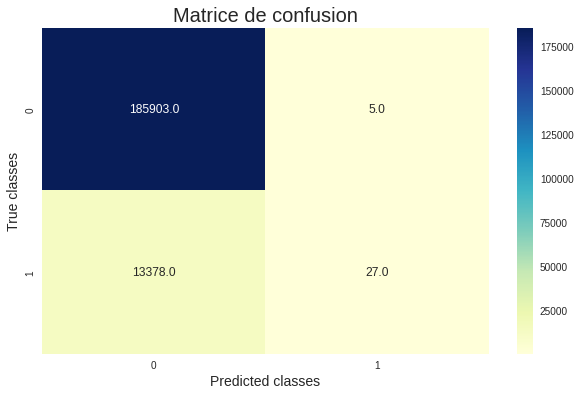

In [ ]:
plt_confusion_matrix(pred_train_df['TARGET'], pred_train_df['predicted_class'])

In [ ]:
pred_test_df = pd.DataFrame(index=X_test.index)
pred_test_df['TARGET'] = y_test
pred_test_df['predicted_class'] = clf.predict(X_test[feats])
pred_test_df.head()

,TARGET,predicted_class
192051,1,0
118313,0,0
47039,0,0
173190,0,0
64025,0,0


              precision    recall  f1-score   support

           0       0.93      1.00      0.97     79804
           1       0.64      0.00      0.00      5617

    accuracy                           0.93     85421
   macro avg       0.79      0.50      0.48     85421
weighted avg       0.92      0.93      0.90     85421



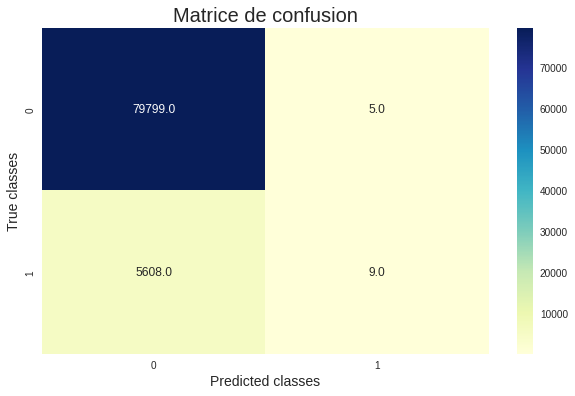

In [ ]:
plt_confusion_matrix(pred_test_df['TARGET'], pred_test_df['predicted_class'])

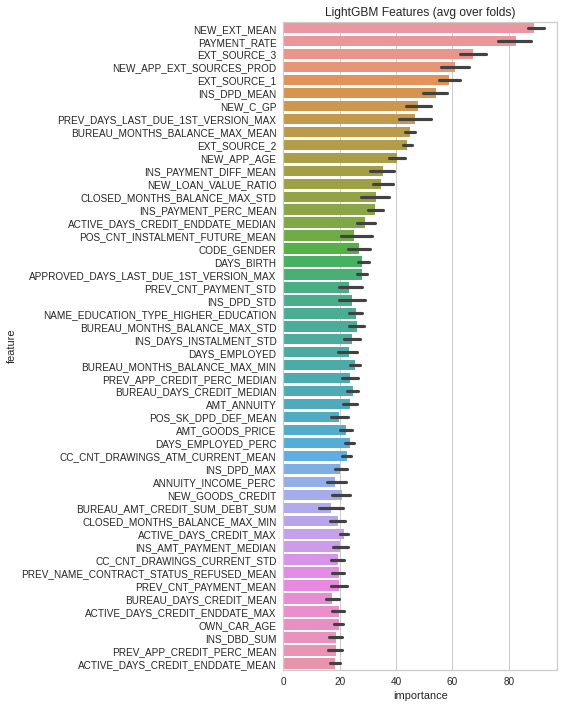

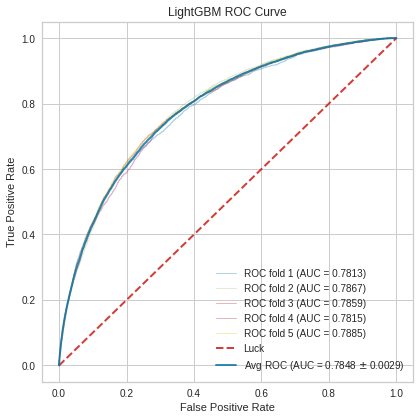

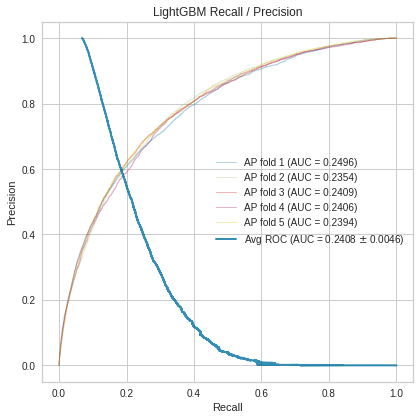

In [ ]:
# Display a few graphs
folds_idx = [(trn_idx, val_idx)
                 for trn_idx, val_idx in folds.split(X_train, y_train)]
display_importances(feature_importance_df_=feature_importance_df)
display_roc_curve(y_=y_train, oof_preds_=pred_train, folds_idx_=folds_idx)
display_precision_recall(y_=y_train, oof_preds_=pred_train, folds_idx_=folds_idx)

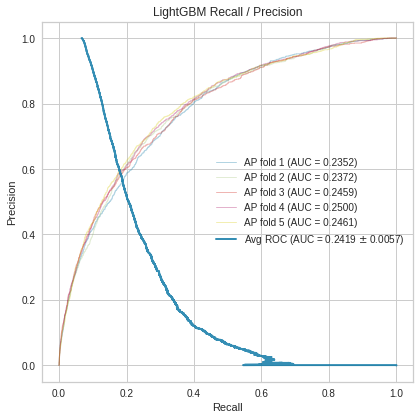

In [ ]:
folds_idx = [(trn_idx, val_idx)
                 for trn_idx, val_idx in folds.split(X_test, y_test)]
display_precision_recall(y_=y_test, oof_preds_=pred_test, folds_idx_=folds_idx)

In [ ]:
model = clf
X = X_test[feats]
explainer = shap.Explainer(model, X)
shap_values = explainer(X, check_additivity=False)

  3%|=                   | 2927/85421 [00:19<08:55]       

In [ ]:
shap.summary_plot(shap_values, X[feats])

In [ ]:
shap.plots.bar(shap_values)

In [ ]:
shap.plots.beeswarm(shap_values)

In [ ]:
shap.plots.scatter(shap_values[:,"DAYS_EMPLOYED"])

## Oversampling

In [116]:
from imblearn.over_sampling import RandomOverSampler

rOs = RandomOverSampler()
X_ro, y_ro = rOs.fit_resample(X_train, y_train)

pred_train_ro = np.zeros(X_ro.shape[0])
pred_test_ro = np.zeros(X_test.shape[0])

# Create Folds
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=1001)

feature_importance_df_ro = pd.DataFrame()

feats = [f for f in X_ro.columns if f not in ['SK_ID_CURR']]

# LightGBM parameters found by Bayesian optimization
clf_ro = LGBMClassifier(
            colsample_bytree=0.9497036,
            #is_unbalance=True,
            feature_fraction=0.2,
            lambda_l1=3.26,
            lambda_l2=2.04,
            learning_rate=0.03,
            max_depth=6,
            min_child_weight=46.65184872316975,
            min_split_gain=0.008032569761590808,
            num_leaves=39,
            nthread=4,
            # n_estimators=10000,
            objective='binary',
            reg_alpha=0.041545473,
            reg_lambda=0.0735294,
            #scale_pos_weight=(282686 / 24825),
            silent=-1,
            subsample=0.8715623,
            # verbose=-1, 
            )

for n_fold, (trn_idx, val_idx) in enumerate(folds.split(X_ro, y_ro)):
    trn_x, trn_y = X_ro[feats].iloc[trn_idx], y_ro.iloc[trn_idx]
    val_x, val_y = X_ro[feats].iloc[val_idx], y_ro.iloc[val_idx]

    clf_ro.fit(trn_x, trn_y,
            eval_set=[(trn_x, trn_y), (val_x, val_y)],
            eval_metric='auc',
            verbose=100,
            early_stopping_rounds=30
            )

    pred_train_ro[val_idx] = clf_ro.predict_proba(val_x,
                                            num_iteration=clf.best_iteration_)[:, 1]
    pred_test_ro += clf_ro.predict_proba(X_test[feats],
                                         num_iteration=clf_ro.best_iteration_)[:, 1] / folds.n_splits
    
    fold_importance_df_ro = pd.DataFrame()
    fold_importance_df_ro["feature"] = feats
    fold_importance_df_ro["importance"] = clf_ro.feature_importances_
    fold_importance_df_ro["fold"] = n_fold + 1
    feature_importance_df_ro = pd.concat([feature_importance_df_ro, fold_importance_df_ro], axis=0)

    print('\n Fold %2d AUC : %.6f' %
              (n_fold + 1, roc_auc_score(val_y, pred_train_ro[val_idx])))
    del trn_x, trn_y, val_x, val_y

print('\n Full AUC score %.6f' % roc_auc_score(y_ro, pred_train_ro))

tcmalloc: large alloc 3340402688 bytes == 0x55ed55c8e000 @  0x7f1abd1eb1e7 0x7f1ab351846e 0x7f1ab3568c7b 0x7f1ab3568d18 0x7f1ab35fb3a9 0x7f1ab35fdab5 0x55e91039a409 0x55e910321e7a 0x55e9103209ee 0x55e9102b3bda 0x55e910322737 0x55e910320ced 0x55e9102b3bda 0x55e910321915 0x55e9102b3afa 0x55e910321c0d 0x55e9102b3afa 0x55e910321c0d 0x55e9103209ee 0x55e9103206f3 0x55e91031eb60 0x55e9102b2349 0x55e9102b2240 0x55e910325973 0x55e9103a5dd5 0x55e910322c6f 0x55e9103a5dd5 0x55e910322c6f 0x55e9103a5dd5 0x55e9102b22ed 0x55e9103a3e1d


[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l1 is set=3.26, reg_alpha=0.041545473 will be ignored. Current value: lambda_l1=3.26
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=0.9497036 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] lambda_l2 is set=2.04, reg_lambda=0.0735294 will be ignored. Current value: lambda_l2=2.04
[100]	training's auc: 0.819257	training's binary_logloss: 0.548672	valid_1's auc: 0.811134	valid_1's binary_logloss: 0.554468

 Fold  1 AUC : 0.811134
[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l1 is set=3.26, reg_alpha=0.041545473 will be ignored. Current value: lambda_l1=3.26
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=0.9497036 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] lamb

In [117]:
pred_train_ro_df = pd.DataFrame(index=X_ro.index)
pred_train_ro_df['predicted_class'] = clf_ro.predict(X_ro[feats])
pred_train_ro_df['TARGET'] = y_ro
pred_train_ro_df.head()

tcmalloc: large alloc 3337420800 bytes == 0x55eed2436000 @  0x7f1abd1eb1e7 0x7f1ab351846e 0x7f1ab3568c7b 0x7f1ab356935f 0x7f1ab360b103 0x55e9102b2544 0x55e9102b2240 0x55e910326627 0x55e9103209ee 0x55e9102b3bda 0x55e910322737 0x55e9103209ee 0x55e9102b3bda 0x55e910322737 0x55e9101f2d14 0x55e9103a3f31 0x55e9103d1849 0x55e9102f6e1a 0x55e910321a7d 0x55e910320ced 0x55e9102b3bda 0x55e910321915 0x55e9103209ee 0x55e9102b3bda 0x55e910321c0d 0x55e9103209ee 0x55e9102b448c 0x55e9102b4698 0x55e910322fe4 0x55e9103209ee 0x55e9102b4271


,predicted_class,TARGET
0,0,0
1,1,1
2,0,0
3,0,0
4,0,0


              precision    recall  f1-score   support

           0       0.75      0.73      0.74    185908
           1       0.74      0.75      0.74    185908

    accuracy                           0.74    371816
   macro avg       0.74      0.74      0.74    371816
weighted avg       0.74      0.74      0.74    371816



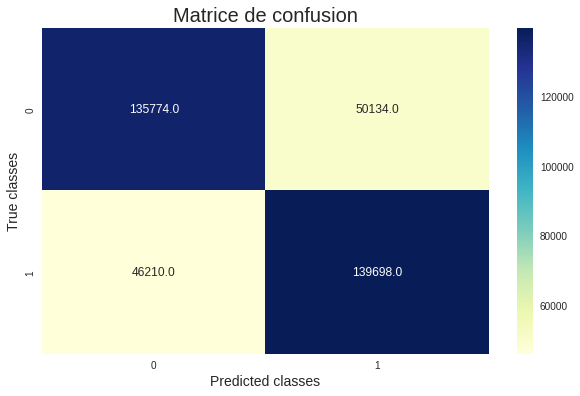

In [118]:
plt_confusion_matrix(pred_train_ro_df['TARGET'], pred_train_ro_df['predicted_class'])

In [124]:
pred_test_ro_df = pd.DataFrame(index=X_test.index)
pred_test_ro_df['TARGET'] = y_test
pred_test_ro_df['predicted_class'] = clf_ro.predict(X_test[feats])
pred_test_ro_df.head()

,TARGET,predicted_class
192051,1,1
118313,0,1
47039,0,0
173190,0,0
64025,0,0


              precision    recall  f1-score   support

           0       0.97      0.73      0.83     79804
           1       0.15      0.69      0.25      5617

    accuracy                           0.72     85421
   macro avg       0.56      0.71      0.54     85421
weighted avg       0.92      0.72      0.79     85421



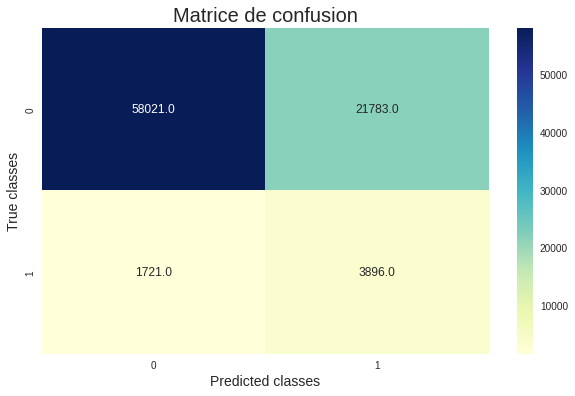

In [125]:
plt_confusion_matrix(pred_test_ro_df['TARGET'], pred_test_ro_df['predicted_class'])

## Undersampling

In [126]:
from imblearn.under_sampling import RandomUnderSampler

rUs = RandomUnderSampler()
X_ru, y_ru = rUs.fit_resample(X_train, y_train)

pred_train_ru = np.zeros(X_ru.shape[0])
pred_test_ru = np.zeros(X_test.shape[0])

# Create Folds
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=1001)

feature_importance_df_ru = pd.DataFrame()

feats = [f for f in X_ru.columns if f not in ['SK_ID_CURR']]

# LightGBM parameters found by Bayesian optimization
clf_ru = LGBMClassifier(
            colsample_bytree=0.9497036,
            #is_unbalance=True,
            feature_fraction=0.2,
            lambda_l1=3.26,
            lambda_l2=2.04,
            learning_rate=0.03,
            max_depth=6,
            min_child_weight=46.65184872316975,
            min_split_gain=0.008032569761590808,
            num_leaves=39,
            nthread=4,
            # n_estimators=10000,
            objective='binary',
            reg_alpha=0.041545473,
            reg_lambda=0.0735294,
            #scale_pos_weight=(282686 / 24825),
            silent=-1,
            subsample=0.8715623,
            # verbose=-1, 
            )

for n_fold, (trn_idx, val_idx) in enumerate(folds.split(X_ru, y_ru)):
    trn_x, trn_y = X_ru[feats].iloc[trn_idx], y_ru.iloc[trn_idx]
    val_x, val_y = X_ru[feats].iloc[val_idx], y_ru.iloc[val_idx]

    clf_ru.fit(trn_x, trn_y,
            eval_set=[(trn_x, trn_y), (val_x, val_y)],
            eval_metric='auc',
            verbose=100,
            early_stopping_rounds=30
            )

    pred_train_ru[val_idx] = clf_ru.predict_proba(val_x,
                                                  num_iteration=clf_ru.best_iteration_)[:, 1]
    pred_test_ru += clf_ru.predict_proba(X_test[feats],
                                         num_iteration=clf_ru.best_iteration_)[:, 1] / folds.n_splits
    
    fold_importance_df_ru = pd.DataFrame()
    fold_importance_df_ru["feature"] = feats
    fold_importance_df_ru["importance"] = clf_ru.feature_importances_
    fold_importance_df_ru["fold"] = n_fold + 1
    feature_importance_df_ru = pd.concat([feature_importance_df_ru, fold_importance_df_ru], axis=0)

    print('\n Fold %2d AUC : %.6f' %
              (n_fold + 1, roc_auc_score(val_y, pred_train_ru[val_idx])))
    del trn_x, trn_y, val_x, val_y

print('\n Full AUC score %.6f' % roc_auc_score(y_ru, pred_train_ru))

[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l1 is set=3.26, reg_alpha=0.041545473 will be ignored. Current value: lambda_l1=3.26
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=0.9497036 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] lambda_l2 is set=2.04, reg_lambda=0.0735294 will be ignored. Current value: lambda_l2=2.04
[100]	training's auc: 0.828766	training's binary_logloss: 0.541691	valid_1's auc: 0.776681	valid_1's binary_logloss: 0.577686

 Fold  1 AUC : 0.776681
[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l1 is set=3.26, reg_alpha=0.041545473 will be ignored. Current value: lambda_l1=3.26
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=0.9497036 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] lamb

In [127]:
pred_train_ru_df = pd.DataFrame(index=X_ru.index)
pred_train_ru_df['predicted_class'] = clf_ru.predict(X_ru[feats])
pred_train_ru_df['TARGET'] = y_ru
pred_train_ru_df.head()

,predicted_class,TARGET
0,0,0
1,0,0
2,1,0
3,0,0
4,0,0


              precision    recall  f1-score   support

           0       0.74      0.74      0.74     13405
           1       0.74      0.74      0.74     13405

    accuracy                           0.74     26810
   macro avg       0.74      0.74      0.74     26810
weighted avg       0.74      0.74      0.74     26810



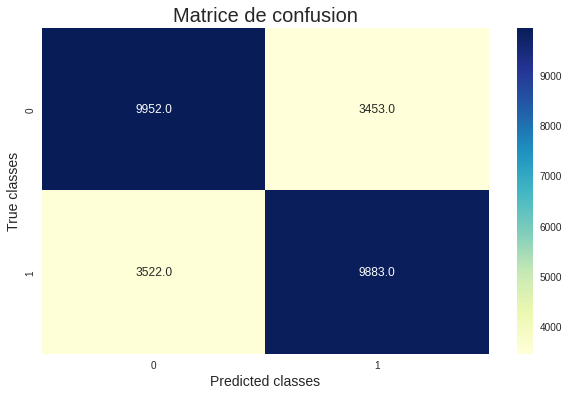

In [128]:
plt_confusion_matrix(pred_train_ru_df['TARGET'], pred_train_ru_df['predicted_class'])

In [129]:
pred_test_ru_df = pd.DataFrame(index=X_test.index)
pred_test_ru_df['TARGET'] = y_test
pred_test_ru_df['predicted_class'] = clf_ru.predict(X_test[feats])

pred_test_ru_df.head()

,TARGET,predicted_class
192051,1,1
118313,0,1
47039,0,0
173190,0,0
64025,0,0


              precision    recall  f1-score   support

           0       0.97      0.71      0.82     79804
           1       0.15      0.71      0.24      5617

    accuracy                           0.71     85421
   macro avg       0.56      0.71      0.53     85421
weighted avg       0.92      0.71      0.78     85421



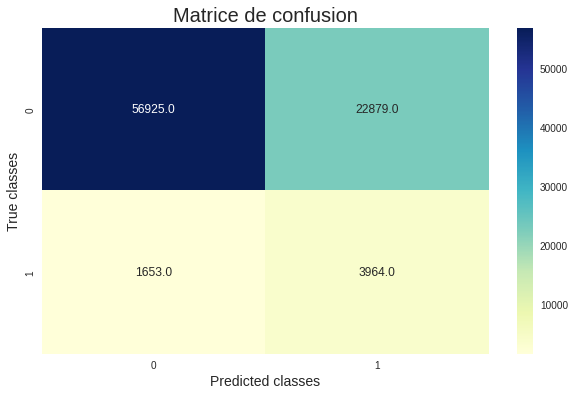

In [130]:
plt_confusion_matrix(pred_test_ru_df['TARGET'], pred_test_ru_df['predicted_class'])

## Custom metric

In [ ]:
def eval_metric_custom(y_true, y_pred):
    
    TP_value = 0
    # on prédit des difficultés et il y en a -> on a raison, pas d'impact
    
    FP_value = 0
    # on prévoit des difficultés mais il n'y en a pas -> pas d'impact pour la banque
    # le manque à gagner et comblé par le modèle, si on passe de FP à TN, on passe de 0 à 1
    
    TN_value = 1
    # On prévoit que tout se passe bien et c'est le cas -> meilleure configuration
    
    FN_value = -10
    # on prévoit que tout se passe bien et il y a des difficultés de paiement
    # -> à éviter au maximum
    
    score = 0 # on initialise le score à 0
    
    # convert probability (y=1) to label with threshold 0.5
    y_pred = np.round(y_pred)
    
    conf_matrix = confusion_matrix(y_true, y_pred)
        
    tn = conf_matrix[0, 0]
    fp = conf_matrix[0, 1]
    fn = conf_matrix[1, 0]
    tp = conf_matrix[1, 1]
    
    gain = tn*TN_value + fp*FP_value + fn*FN_value + tp*TP_value
    
    perfect_model = (tn + fp)*TN_value + (fn + tp)*TP_value
    # modèle parfait qui prédit les vraies classes
    
    no_model = (tn + fp)*TN_value + (tp + fn)*FN_value
    # modèle qui refuse tous les prêts
    
    score = (gain - no_model) / (perfect_model - no_model)
    # on normalise le gain : score de 1 pour un modèle parfait 
    # et 0 pour un modèle qui dit toujours non
    
    #print('score :', score)
    
    return 'score', score, True  

In [ ]:
eval_metric_custom(pred_train_ru_df['TARGET'], pred_train_ru_df['predicted_class'])

('score', 0.7154942185751585, True)

In [ ]:
eval_metric_custom(pred_test_ru_df['TARGET'], pred_test_ru_df['predicted_class'])

('score', 0.2916147409649279, True)

In [ ]:
eval_metric_custom([0, 1, 0, 0, 0, 1], [0.15, 0.8, 0.19, 0.9, 0.08, 0.8])

('score', 0.95, True)

In [ ]:
def feval_metric_custom(preds, train_data):
    
    y_true = train_data.get_label()
    y_pred = preds
    
    eval_name, eval_result, is_higher_better = eval_metric_custom(y_true, y_pred)
    
    return eval_name, eval_result, is_higher_better

In [ ]:
# prepare data
ru_data = lgb.Dataset(data=X_ru, label=y_ru, free_raw_data=False)

# parameters
def lgb_eval(feature_fraction, lambda_l1, lambda_l2, max_depth,
             min_child_weight, min_split_gain, num_leaves):
    
    params = {'application': 'binary',
              'colsample_bytree':0.9497036,
              'early_stopping_round':30,
              'learning_rate':0.03,
              'num_iterations': 10000,
              'reg_alpha':0.041545473,
              'reg_lambda':0.0735294,
              'subsample':0.871562
             }
    params["num_leaves"] = int(round(num_leaves))
    params['feature_fraction'] = max(min(feature_fraction, 1), 0)
    params['max_depth'] = int(round(max_depth))
    params['lambda_l1'] = max(lambda_l1, 0)
    params['lambda_l2'] = max(lambda_l2, 0)
    params['min_split_gain'] = min_split_gain
    params['min_child_weight'] = min_child_weight
    
    cv_result = lgb.cv(params, ru_data, nfold=5,
                       seed=6,verbose_eval =200,
                       feval=feval_metric_custom,
                       return_cvbooster=True)
    print(cv_result)
    return max(cv_result['score-mean'])

# optimisation des hyperparamètres sur le jeu d'entrainement
params_BO = {
          'feature_fraction': (0.1, 0.9),
          'lambda_l1': (0, 5),
          'lambda_l2': (0, 3),
          'max_depth': (5, 9),
          'min_child_weight': (5, 50),
          'min_split_gain': (0.001, 0.1),
          'num_leaves': (24, 45)
         }

# range 
lgbBO_ru = BayesianOptimization(lgb_eval, pbounds=params_BO, random_state=0)


In [ ]:
lgb_eval(0.1, 1, 1, 5, 5, 0.003, 24)

[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.041545473 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0735294 will be ignored. Current value: lambda_l2=1
[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=0.9497036 will be ignored. Current value: feature_fraction=0.1
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.041545473 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0735294 will be ignored. Current value: lambda_l2=1
[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=0.9497036 will be ignored. Current value: feature_fraction=0.1
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.041545473 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0735294 will be ignored. Current value: lambda_l2=1
[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=0.9497036 will be ignored. Current

0.676580224232697

In [ ]:
# optimize
# lgbBO_ru.maximize(init_points=2, n_iter=3)

In [ ]:
lgbBO_ru.max
{'target': 0.6888952100535931,
 'params': {'feature_fraction': 0.8134184006256638,
  'lambda_l1': 4.818313802505147,
  'lambda_l2': 1.150324556477333,
  'max_depth': 8.166900152330658,
  'min_child_weight': 28.800271388880702,
  'min_split_gain': 0.0572364115482993,
  'num_leaves': 43.43752940414588}}

{'target': 0.6888952100535931,
 'params': {'feature_fraction': 0.8134184006256638,
  'lambda_l1': 4.818313802505147,
  'lambda_l2': 1.150324556477333,
  'max_depth': 8.166900152330658,
  'min_child_weight': 28.800271388880702,
  'min_split_gain': 0.0572364115482993,
  'num_leaves': 43.43752940414588}}

In [ ]:
rUs = RandomUnderSampler()
X_ru, y_ru = rUs.fit_resample(X_train, y_train)

pred_train_ru_final = np.zeros(X_ru.shape[0])
pred_test_ru_final = np.zeros(X_test.shape[0])

# Create Folds
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=1001)

feature_importance_df_ru_final = pd.DataFrame()

feats = [f for f in X_ru.columns if f not in ['SK_ID_CURR']]

# LightGBM parameters found by Bayesian optimization
clf_ru_final = LGBMClassifier(
                colsample_bytree=0.9497036,
                feature_fraction=0.8,
                lambda_l1=4.818,
                lambda_l2=1.150,
                learning_rate=0.03,
                max_depth=8,
                min_child_weight=28.800271388880702,
                min_split_gain=0.0572364115482993,
                num_leaves=43,
                nthread=4,
                # n_estimators=10000,
                objective='binary',
                reg_alpha=0.041545473,
                reg_lambda=0.0735294,
                silent=-1,
                subsample=0.8715623,
                # verbose=-1 
                )

for n_fold, (trn_idx, val_idx) in enumerate(folds.split(X_ru, y_ru)):
    trn_x, trn_y = X_ru[feats].iloc[trn_idx], y_ru.iloc[trn_idx]
    val_x, val_y = X_ru[feats].iloc[val_idx], y_ru.iloc[val_idx]

    clf_ru_final.fit(trn_x, trn_y,
                     eval_set=[(trn_x, trn_y), (val_x, val_y)],
                     eval_metric=eval_metric_custom,
                     verbose=100,
                     early_stopping_rounds=30
                     )

    pred_train_ru_final[val_idx] = clf_ru_final.predict(val_x,
                                                        num_iteration=clf_ru_final.best_iteration_)
    pred_test_ru_final += clf_ru_final.predict(X_test[feats],
                                               num_iteration=clf_ru_final.best_iteration_) / folds.n_splits
    
    fold_importance_df_ru_final = pd.DataFrame()
    fold_importance_df_ru_final["feature"] = feats
    fold_importance_df_ru_final["importance"] = clf_ru_final.feature_importances_
    fold_importance_df_ru_final["fold"] = n_fold + 1
    feature_importance_df_ru_final = pd.concat([feature_importance_df_ru_final,
                                                fold_importance_df_ru_final], axis=0)


    eval_name, eval_result, is_higher_better = eval_metric_custom(val_y, pred_train_ru_final[val_idx])
    
    print('\n Fold %2d score : %.6f' %
              (n_fold + 1, eval_result))
    del trn_x, trn_y, val_x, val_y, eval_name, eval_result, is_higher_better

eval_name, eval_result, is_higher_better = eval_metric_custom(y_ru, pred_train_ru_final)
print('\n Full score %.6f' % eval_result)

[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l1 is set=4.818, reg_alpha=0.041545473 will be ignored. Current value: lambda_l1=4.818
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=0.9497036 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=1.15, reg_lambda=0.0735294 will be ignored. Current value: lambda_l2=1.15
[100]	training's binary_logloss: 0.526972	training's score: 0.726492	valid_1's binary_logloss: 0.571364	valid_1's score: 0.680896

 Fold  1 score : 0.680896
[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l1 is set=4.818, reg_alpha=0.041545473 will be ignored. Current value: lambda_l1=4.818
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=0.9497036 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [War

In [ ]:
filename = source_path + 'LightGBMModel.pkl'
outfile = open(filename,'wb')
pickle.dump(clf_ru_final, outfile)
outfile.close()

NameError: ignored

In [ ]:
pred_train_ru_final_df = pd.DataFrame(index=X_ru.index)
pred_train_ru_final_df['predicted_class'] = clf_ru_final.predict(X_ru[feats])
pred_train_ru_final_df['TARGET'] = y_ru
pred_train_ru_final_df.head()

,predicted_class,TARGET
0,0.00,0.00
1,0.00,0.00
2,0.00,0.00
3,1.00,0.00
4,0.00,0.00


              precision    recall  f1-score   support

         0.0       0.74      0.75      0.75     17302
         1.0       0.75      0.74      0.74     17302

    accuracy                           0.74     34604
   macro avg       0.74      0.74      0.74     34604
weighted avg       0.74      0.74      0.74     34604



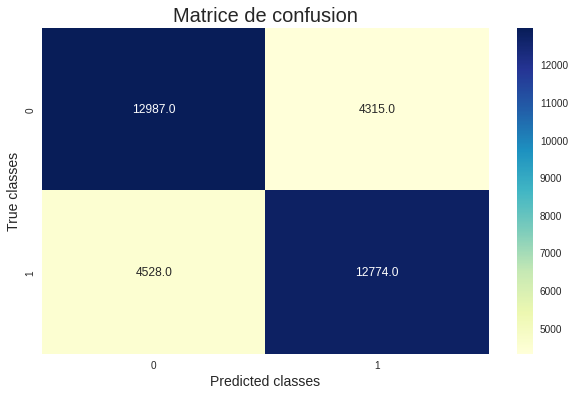

In [ ]:
plt_confusion_matrix(pred_train_ru_final_df['TARGET'], pred_train_ru_final_df['predicted_class'])

In [ ]:
pred_test_ru_final_df = pd.DataFrame(index=X_test.index)
pred_test_ru_final_df['TARGET'] = y_test
pred_test_ru_final_df['predicted_class'] = clf_ru_final.predict(X_test[feats])
pred_test_ru_final_df.head()

,TARGET,predicted_class
183386,0,1.00
205374,0,0.00
322669,0,0.00
22493,0,0.00
90399,0,0.00


              precision    recall  f1-score   support

           0       0.97      0.71      0.82     99352
           1       0.16      0.71      0.26      7523

    accuracy                           0.71    106875
   macro avg       0.56      0.71      0.54    106875
weighted avg       0.91      0.71      0.78    106875



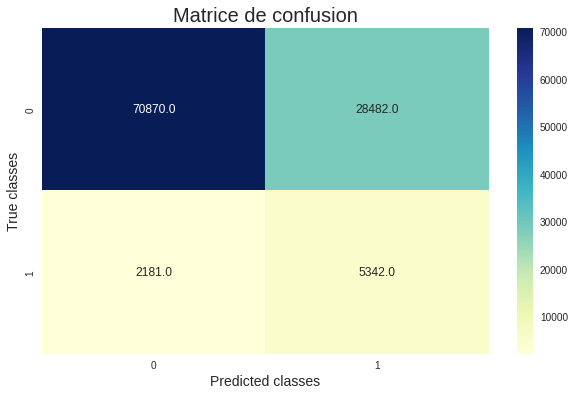

In [ ]:
plt_confusion_matrix(pred_test_ru_final_df['TARGET'], pred_test_ru_final_df['predicted_class'])

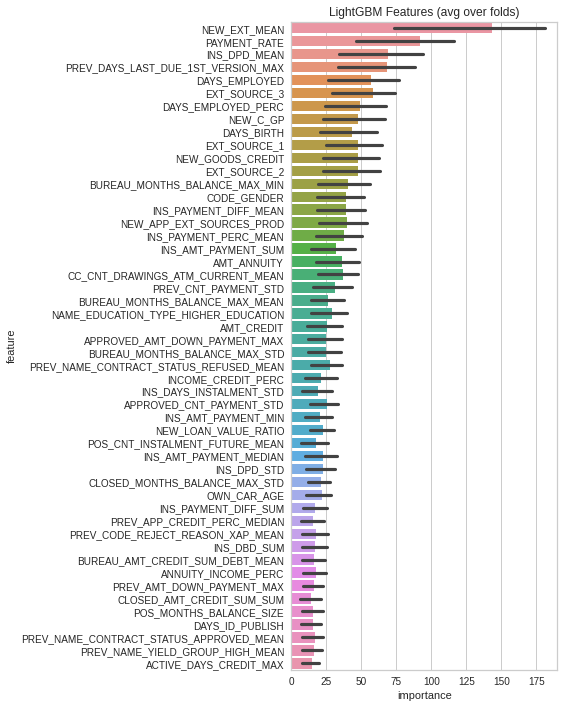

In [ ]:
# Display a few graphs
folds_idx = [(trn_idx, val_idx)
                 for trn_idx, val_idx in folds.split(X_ru, y_ru)]
display_importances(feature_importance_df_ = feature_importance_df_ru_final)

## Custom metric avec seuil

In [ ]:
def eval_metric_custom(y_true, y_pred):
    
    TP_value = 0
    # on prédit des difficultés et il y en a -> on a raison, pas d'impact
    
    FP_value = 0
    # on prévoit des difficultés mais il n'y en a pas -> pas d'impact pour la banque
    # le manque à gagner et comblé par le modèle, si on passe de FP à TN, on passe de 0 à 1
    
    TN_value = 1
    # On prévoit que tout se passe bien et c'est le cas -> meilleure configuration
    
    FN_value = -10
    # on prévoit que tout se passe bien et il y a des difficultés de paiement
    # -> à éviter au maximum
    
    score_final = 0 # on initialise le score à 0
        
    for proba in np.linspace(0.01,0.3,100):  # on teste le seuil de probabilité
        y_pred_proba = np.array(y_pred)
        
        for i in range(y_pred_proba.shape[0]):
        
            # convert probability to label with threshold 'proba'
            if y_pred_proba[i]<proba:
                y_pred_proba[i] = 0
            else:
                y_pred_proba[i] = 1
    
        conf_matrix = confusion_matrix(y_true, y_pred_proba)
        
        tn = conf_matrix[0, 0]
        fp = conf_matrix[0, 1]
        fn = conf_matrix[1, 0]
        tp = conf_matrix[1, 1]
    
        gain = tn*TN_value + fp*FP_value + fn*FN_value + tp*TP_value
    
        perfect_model = (tn + fp)*TN_value + (fn + tp)*TP_value
        # modèle parfait qui prédit les vraies classes
    
        no_model = (tn + fp)*TN_value + (tp + fn)*FN_value
        # modèle qui prédit toujours 0
    
        score = (gain - no_model) / (perfect_model - no_model)
        # on normalise le gain : score de 1 pour un modèle parfait 
        # et 0 pour un modèle qui dit toujours non
        
        if score > score_final:
            score_final = score
            threshold = proba
    
    print('seuil pour maximiser les profits :{}'.format(threshold))
    
    return 'score', score_final, True

In [ ]:
eval_metric_custom(pred_train_ru_df['TARGET'], pred_train_ru_df['predicted_class'])

seuil pour maximiser les profits :0.01


('score', 0.7137498555080337, True)

In [ ]:
eval_metric_custom(pred_test_ru_df['TARGET'], pred_test_ru_df['predicted_class'])

seuil pour maximiser les profits :0.01


('score', 0.329974744118038, True)

In [ ]:
eval_metric_custom([0, 1, 0, 0, 0, 1], [0.15, 0.8, 0.19, 0.9, 0.08, 0.8])

seuil pour maximiser les profits :0.1916161616161616


('score', 0.95, True)

In [ ]:
def feval_metric_custom(preds, train_data):
    
    y_true = train_data.get_label()
    y_pred = preds
    
    eval_name, eval_result, is_higher_better = eval_metric_custom(y_true, y_pred)
    
    return eval_name, eval_result, is_higher_better

In [ ]:
# prepare data
ru_data = lgb.Dataset(data=X_ru, label=y_ru, free_raw_data=False)

# parameters
def lgb_eval(feature_fraction, lambda_l1, lambda_l2, max_depth,
             min_child_weight, min_split_gain, num_leaves):
    
    params = {'application': 'binary',
              'colsample_bytree':0.9497036,
              'early_stopping_round':30,
              'learning_rate':0.03,
              'num_iterations': 10000,
              'reg_alpha':0.041545473,
              'reg_lambda':0.0735294,
              'subsample':0.871562
             }
    params["num_leaves"] = int(round(num_leaves))
    params['feature_fraction'] = max(min(feature_fraction, 1), 0)
    params['max_depth'] = int(round(max_depth))
    params['lambda_l1'] = max(lambda_l1, 0)
    params['lambda_l2'] = max(lambda_l2, 0)
    params['min_split_gain'] = min_split_gain
    params['min_child_weight'] = min_child_weight
    
    cv_result = lgb.cv(params, ru_data, nfold=5,
                       seed=6,verbose_eval =200,
                       feval=feval_metric_custom,
                       return_cvbooster=True)
    print(cv_result)
    return max(cv_result['score-mean'])

# optimisation des hyperparamètres sur le jeu d'entrainement
params_BO = {
          'feature_fraction': (0.1, 0.9),
          'lambda_l1': (0, 5),
          'lambda_l2': (0, 3),
          'max_depth': (5, 9),
          'min_child_weight': (5, 50),
          'min_split_gain': (0.001, 0.1),
          'num_leaves': (24, 45)
         }

# range 
lgbBO_ru = BayesianOptimization(lgb_eval, pbounds=params_BO, random_state=0)


In [ ]:
# optimize
# lgbBO_ru.maximize(init_points=2, n_iter=3)

In [ ]:
lgbBO_ru.max
{'target': 0.9018719075129937,
 'params': {'feature_fraction': 0.894127419305972,
  'lambda_l1': 2.9699162251902895,
  'lambda_l2': 2.1674963923113335,
  'max_depth': 5.936095408808049,
  'min_child_weight': 34.467860391741226,
  'min_split_gain': 0.0028128962349801634,
  'num_leaves': 24.19938683432061}}

{'target': 0.9018719075129937,
 'params': {'feature_fraction': 0.894127419305972,
  'lambda_l1': 2.9699162251902895,
  'lambda_l2': 2.1674963923113335,
  'max_depth': 5.936095408808049,
  'min_child_weight': 34.467860391741226,
  'min_split_gain': 0.0028128962349801634,
  'num_leaves': 24.19938683432061}}

In [ ]:
rUs = RandomUnderSampler()
X_ru, y_ru = rUs.fit_resample(X_train, y_train)

pred_train_cm_final = np.zeros(X_ru.shape[0])
pred_test_cm_final = np.zeros(X_test.shape[0])

# Create Folds
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=1001)

feature_importance_df_cm_final = pd.DataFrame()

feats = [f for f in X_ru.columns if f not in ['SK_ID_CURR']]

# LightGBM parameters found by Bayesian optimization
clf_cm_final = LGBMClassifier(
                colsample_bytree=0.9497036,
                feature_fraction=0.9,
                lambda_l1=2.9699,
                lambda_l2=2.1675,
                learning_rate=0.03,
                max_depth=6,
                min_child_weight=34.467860391741226,
                min_split_gain=0.0028128962349801634,
                num_leaves=24,
                nthread=4,
                # n_estimators=10000,
                objective='binary',
                reg_alpha=0.041545473,
                reg_lambda=0.0735294,
                silent=-1,
                subsample=0.8715623,
                verbose=-1 )

for n_fold, (trn_idx, val_idx) in enumerate(folds.split(X_ru, y_ru)):
    trn_x, trn_y = X_ru[feats].iloc[trn_idx], y_ru.iloc[trn_idx]
    val_x, val_y = X_ru[feats].iloc[val_idx], y_ru.iloc[val_idx]

    clf_cm_final.fit(trn_x, trn_y,
                     eval_set=[(trn_x, trn_y), (val_x, val_y)],
                     eval_metric=eval_metric_custom,
                     verbose=100,
                     early_stopping_rounds=30
                     )

    pred_train_cm_final[val_idx] = clf_cm_final.predict_proba(val_x,
                                                              num_iteration=clf_cm_final.best_iteration_)[:, 0] / folds.n_splits
    pred_test_cm_final += clf_cm_final.predict_proba(X_test[feats],
                                                     num_iteration=clf_cm_final.best_iteration_)[:, 0] / folds.n_splits
    
    fold_importance_df_cm_final = pd.DataFrame()
    fold_importance_df_cm_final["feature"] = feats
    fold_importance_df_cm_final["importance"] = clf_cm_final.feature_importances_
    fold_importance_df_cm_final["fold"] = n_fold + 1
    feature_importance_df_cm_final = pd.concat([feature_importance_df_cm_final,
                                                fold_importance_df_cm_final], axis=0)


    eval_name, eval_result, is_higher_better = eval_metric_custom(val_y, pred_train_cm_final[val_idx])
    
    print('\n Fold %2d score : %.6f' %
              (n_fold + 1, eval_result))
    del trn_x, trn_y, val_x, val_y, eval_name, eval_result, is_higher_better

eval_name, eval_result, is_higher_better = eval_metric_custom(y_ru, pred_train_cm_final)
print('\n Full score %.6f' % eval_result)

seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les profits :0.01
seuil pour maximiser les 

KeyboardInterrupt: ignored

In [ ]:
filename = source_path + 'LightGBMModel.pkl'
outfile = open(filename,'wb')
dump(clf_cm_final, outfile)
outfile.close()

In [ ]:
pred_train_cm_final_df = pd.DataFrame(index=X_ru.index)
pred_train_cm_final_df['predicted_class'] = clf_cm_final.predict(X_ru[feats])
pred_train_cm_final_df['TARGET'] = y_ru
pred_train_cm_final_df.head()

In [ ]:
plt_confusion_matrix(pred_train_cm_final_df['TARGET'], pred_train_cm_final_df['predicted_class'])

In [ ]:
pred_test_cm_final_df = pd.DataFrame(index=X_test.index)
pred_test_cm_final_df['TARGET'] = y_test
pred_test_cm_final_df['predicted_class'] = clf_cm_final.predict(X_test[feats])
pred_test_cm_final_df.head()

In [ ]:
plt_confusion_matrix(pred_test_cm_final_df['TARGET'], pred_test_cm_final_df['predicted_class'])

In [ ]:
display_importances(feature_importance_df_ = feature_importance_df_cm_final)

# 10. Interprétabilité

In [131]:
# explainer = shap.TreeExplainer(clf_cm_final)
explainer = shap.TreeExplainer(clf_ru)
shap_values = explainer.shap_values(X_test[feats])

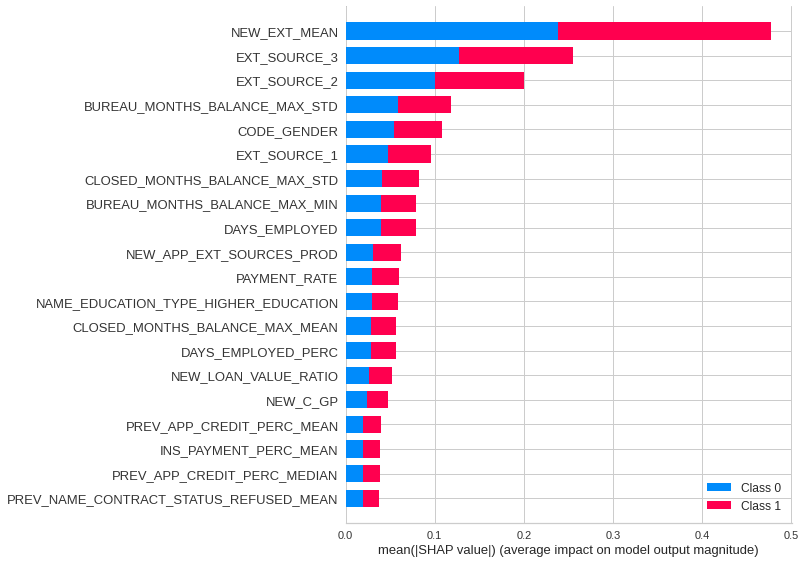

In [132]:
shap.summary_plot(shap_values, X_test[feats])

In [133]:
# model = clf_cm_final
model = clf_ru
X = X_test[feats]
explainer = shap.Explainer(model, X)
shap_values = explainer(X, check_additivity=False)

100%|===================| 85294/85421 [08:59<00:00]       

## Global

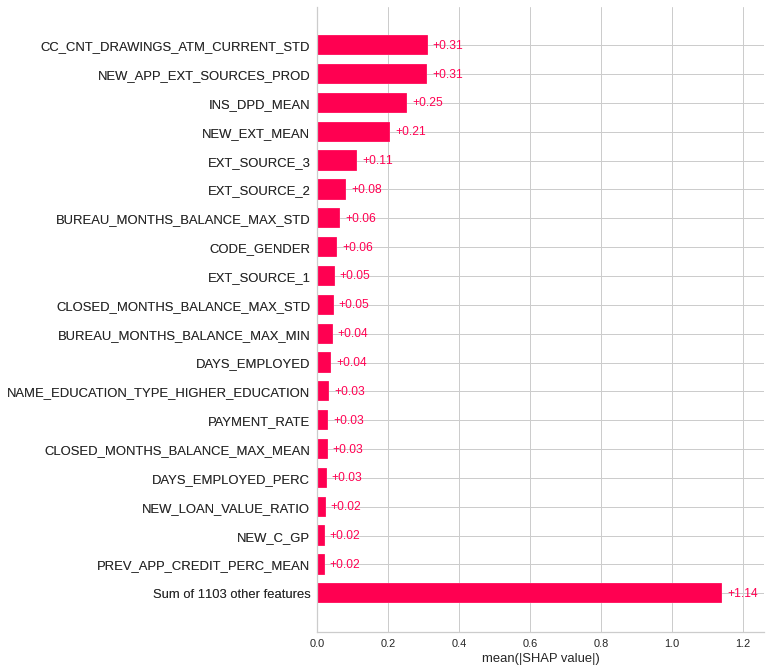

In [141]:
shap.plots.bar(shap_values,max_display=20)

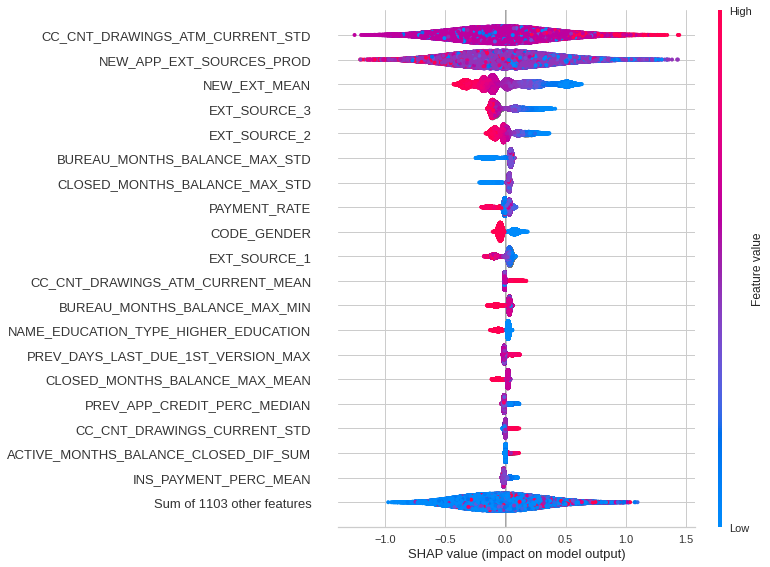

In [140]:
shap.plots.beeswarm(shap_values, max_display=20,order=shap_values.abs.max(0))

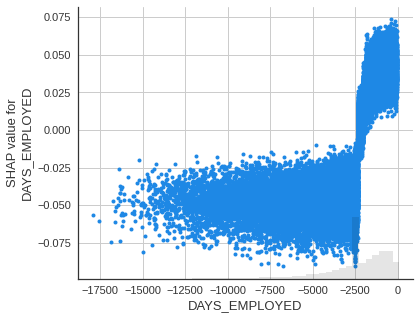

In [136]:
shap.plots.scatter(shap_values[:,"DAYS_EMPLOYED"])

## Local

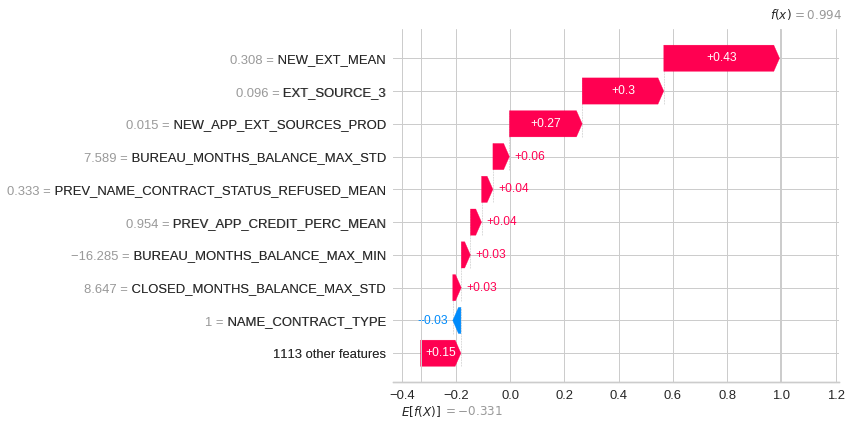

In [137]:
shap.plots.waterfall(shap_values[0])

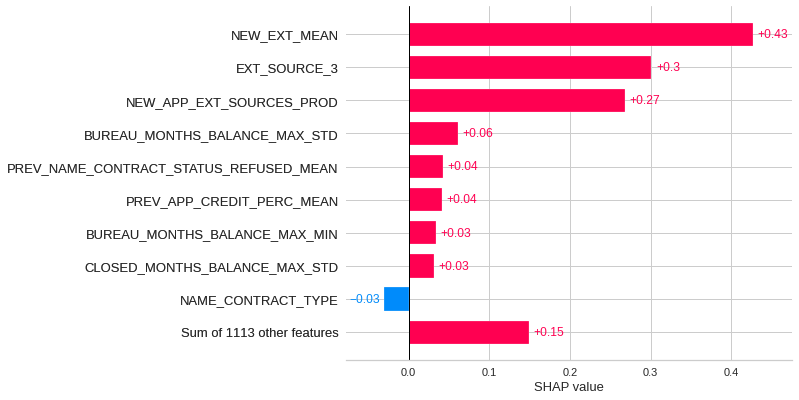

In [138]:
shap.plots.bar(shap_values[0])